<a href="https://colab.research.google.com/github/ahn283/finance/blob/main/deep_learning_cnn_architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Library:** 분석에 사용할 모듈 설치

In [1]:
# !pip install --upgrade pip
# !python -m pip install --user --upgrade pip

In [2]:
# # Tensorflow 및 Keras 설치하기
# !pip install tensorflow==2.10.*
# # !pip install --upgrade --user tensorflow
# !pip install -U tensorflow-addons
# !pip install keras
# # !pip install --upgrade --user keras
# !pip install keras-tqdm

In [3]:
# Ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation and visiualization
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 20
pd.options.display.max_columns = 20
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

## Modeling algorithms
# General
import statsmodels.api as sm
from scipy import stats
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.get_logger().warning('test')
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Dropout, Reshape
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.utils import plot_model

# Model selection
from sklearn.model_selection import train_test_split, GridSearchCV

# Evaluation metrics
from sklearn import metrics
# for regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve

In [4]:
# Module regression

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import statsmodels.api as sm 
from scipy import stats 
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


### Boston Housing Price
# 자료형 변환 + 결측값 처리
def prep(df_origin):
    df = df_origin.copy()
    
    # 자료형 변환
    col = []
    if df['ZN'].dtype == 'object':
        for i in df['ZN']:
            col.append(float(i[1:-1]))
        df['ZN'] = col

    col = []
    if df['CHAS'].dtype == 'object':
        for i in df['CHAS']:
            col.append(float(i[1:-1]))
        df['CHAS'] = col

    # 결측값 처리
    for i in df.columns[df.isnull().sum() != 0]:
        if i not in ['INDUS', 'RM']:
            df[i].fillna(df[i].mean(), inplace=True)
        else:
            df[i].fillna(df[i].median(), inplace=True)
            
    return df

# 데이터 변환
def feature_engineering(df_origin):
    df = df_origin.copy()
    
    interval = [100, 200, 300, 400, 500, 600, 700, 800]
    if df['TAX'].max() >= 100:
        df['TAX'] = np.digitize(df['TAX'], bins=interval)
        
    if 'TAX' in df.columns:
        df_dummy = pd.get_dummies(df['TAX'], prefix='TAX', drop_first=True)
        df = pd.concat([df, df_dummy], axis=1)
        del df['TAX']

    if 'CHAS' in df.columns:
        df['CHAS'] = df['CHAS'].astype(int)
        df_dummy = pd.get_dummies(df['CHAS'], prefix='CHAS', drop_first=False)
        df = pd.concat([df, df_dummy], axis=1)
        del df['CHAS']
    
    return df


# 데이터 분리
def datasplit(df, Y_colname, test_size=0.2, random_state=123):
    X_colname = [x for x in df.columns if x not in Y_colname]
       
    X_train, X_test, Y_train, Y_test = train_test_split(df[X_colname], df[Y_colname],
                                                        test_size=test_size, random_state=random_state)
    print(X_train.shape, Y_train.shape)
    print(X_test.shape, Y_test.shape)
    
    return X_train, X_test, Y_train, Y_test

# 데이터 변환 후 X_train, X_test의 변수 갯수 일치
def col_mapping(X_train, X_test):
    X_tr = X_train.copy()
    X_te = X_test.copy()
    
    # Train & Test 변수명 체크
    X_te_noncol = [i for i in X_tr.columns if i not in X_te.columns]
    X_tr_noncol = [i for i in X_te.columns if i not in X_tr.columns]

    # 변수 갯수 일치
    if X_te_noncol != []:
        for i in X_te_noncol:
            X_te[i] = 0
            X_te = X_te[X_tr.columns].copy()
            
    if X_tr_noncol != []:
        for i in X_tr_noncol:
            X_tr[i] = 0
            X_tr = X_tr[X_te.columns].copy()
            
    return X_tr, X_te

# 스케쥴 조정
def scale(scaler, X_train, X_test):
    scaler_fit = scaler.fit(X_train)
    X_train_scaling = pd.DataFrame(scaler_fit.transform(X_train), 
                                   index=X_train.index, columns=X_train.columns)
    X_test_scaling = pd.DataFrame(scaler_fit.transform(X_test), 
                                  index=X_test.index, columns=X_test.columns)
    
    return X_train_scaling, X_test_scaling

# 실제 Y와 예측치 시각화
def plot_prediction(Y_true_pred):
    plt.figure(figsize=(16, 8))
    plt.plot(Y_true_pred, linewidth=5, label=Y_true_pred.columns)
    plt.xticks(fontsize=25, rotation=0)
    plt.yticks(fontsize=25)
    plt.xlabel('Index', fontname='serif', fontsize=28)
    plt.legend(fontsize=20)
    plt.grid()
    plt.show()

# 검증 함수화
def evaluation_reg(Y_real, Y_pred):
    MAE = mean_absolute_error(Y_real, Y_pred)
    MSE = mean_squared_error(Y_real, Y_pred)
    MAPE = mean_absolute_percentage_error(Y_real, Y_pred)
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    
    return Score

# Train & Test 모두의 검증 함수화
def evaluation_reg_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te):
    Score_tr = evaluation_reg(Y_real_tr, Y_pred_tr)
    Score_te = evaluation_reg(Y_real_te, Y_pred_te)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']

    return Score_trte

# 에러 분석
def error_analysis(X_Data, Y_Pred, Residual, graph_on=False):
    if graph_on == True:
        ##### 시각화
        # 잔차의 정규본포성 확인
        # sns.displot(Residual, norm_hist='True', fit=stats.norm)
        sns.displot(Residual, kind='hist')
        plt.show()

        # 잔차의 등분산성 확인
        temp = pd.concat([Y_Pred, Residual.reset_index().iloc[:,[1]]], axis=1)
        sns.scatterplot(x='Pred', y='Error', data=temp)
        plt.show()
        
        # 잔차의 자기상관성 확인
        sm.graphics.tsa.plot_acf(Residual, lags=50, use_vlines=True)
        plt.show()

    ##### 통계량
    # 정규분포
    # Null Hypothesis: The residuals are normally distributed
    Normality = pd.DataFrame([stats.shapiro(Residual)], 
                             index=['Normality'], columns=['Test Statistics', 'p-value']).T

    # 등분산성
    # Null Hypothesis: Error terms are homoscedastic
    Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Residual, X_Data.values, alternative='two-sided')],
                                      index=['Heteroscedasticity'], 
                                      columns=['Test Statistics', 'p-value', 'Alternative']).T
    
    # 자기상관
    # Null Hypothesis: Autocorrelation is absent
    Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Residual, lags=[10,50]).iloc[:,0]),
                             pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Residual, lags=[10,50]).iloc[:,1])], axis=1).T
    Autocorrelation.index = ['Test Statistics', 'p-value']
    Autocorrelation.columns = ['Autocorr(lag10)', 'Autocorr(lag50)']
    
    Error_Analysis = pd.concat([Normality, Heteroscedasticity, Autocorrelation], join='outer', axis=1)
    
    return Error_Analysis

In [5]:
# Module classificaion

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve



### Titanic
# 결측값 처리
def fillnull(df):
    ## Age
    df_agem = df[df.Sex == 'male']
    df_agem = df_agem[['Age']].fillna(df_agem[['Age']].mean())

    df_agefm = df[df.Sex == 'female']
    df_agefm = df_agefm[['Age']].fillna(df_agefm[['Age']].mean())
    df[['Age']] = pd.concat([df_agem, df_agefm], axis=0).sort_index()

    ## Embarked
    df[['Embarked']] = df[['Embarked']].fillna(df['Embarked'].mode()[0], axis=0)

    ## Cabin
    df['Cabin'] = df['Cabin'].str.slice(0,1)
    df['Cabin'] = df['Cabin'].fillna('Temp')
    
    return df


# 데이터 정리
def prep(df):
    # Name
    name_sub = df['Name'].str.split(',', expand=True)[1]
    name_sub = name_sub.str.split('. ', expand=True)[0]
    name_sub.replace([' Mr'], 'Mr', inplace=True)
    name_sub.replace([' Mrs'], 'Mrs', inplace=True)
    name_sub.replace([' Ms', ' Miss'], 'Miss', inplace=True)
    name_sub.replace([' Don', ' Mme', ' Lady', 'Sir', 'Mlle', ' th', ' Jonkheer'], 'Noble', inplace=True)
    name_sub.replace([' Master', ' Major', ' Col', ' Capt', ' Sir', ' Mlle', ' Jonkheer'], 'Officer', inplace=True)
    name_sub.replace([' Dr', ' Rev'], 'Priest', inplace=True)
    df['Name'] = name_sub.copy()

    # Ticket
    df['Ticket'] = df['Ticket'].str.replace('.','').str.replace('/','')
    df['Ticket'] = df['Ticket'].str.strip().str.split(' ').str[0]
    df.loc[df['Ticket'].str.isdigit(), 'Ticket'] = 'NUM'

    # Age
    age_interval = [10, 20, 30, 40, 50, 60, 70, 80, 90]
    if df['Age'].max() > len(age_interval):
        df['Age'] = np.digitize(df['Age'], bins=age_interval)
        
    return df


# 데이터 분리
def datasplit(df, Y_colname, test_size=0.2, random_state=123):
    X_colname = [x for x in df.columns if x not in Y_colname]
       
    X_train, X_test, Y_train, Y_test = train_test_split(df[X_colname], df[Y_colname],
                                                        test_size=test_size, random_state=random_state)
    print(X_train.shape, Y_train.shape)
    print(X_test.shape, Y_test.shape)
    
    return X_train, X_test, Y_train, Y_test


# 데이터 변환
def label_encoding(X_train, X_test, colname, encoder):
    X_train_le = X_train.copy()
    X_test_le = X_test.copy()
    
    for i in colname: # 대상 변수들마다
        encoder = encoder.fit(X_train[i])

        for label in X_test[i].unique():
            if label not in encoder.classes_:
                encoder.classes_ = np.append(encoder.classes_, label)

        X_train_le[i] = encoder.transform(X_train[i])
        X_test_le[i] = encoder.transform(X_test[i])
        
    return X_train_le, X_test_le


def onehot_encoding(df, colname):
    df_ohe = df.copy()
    
    for i in colname:
        if i in df.columns:
            df_ohe = pd.get_dummies(df_ohe, columns=[i], drop_first=True)
            
    return df_ohe


# 데이터 변환 후 X_train과 X_test의 변수 갯수 일치
def col_mapping(X_train, X_test):
    X_tr = X_train.copy()
    X_te = X_test.copy()
    
    # Train & Test 변수명 체크
    X_te_noncol = [i for i in X_tr.columns if i not in X_te.columns]
    X_tr_noncol = [i for i in X_te.columns if i not in X_tr.columns]

    # 변수 갯수 일치
    if X_te_noncol != []:
        for i in X_te_noncol:
            X_te[i] = 0
            X_te = X_te[X_tr.columns].copy()
            
    if X_tr_noncol != []:
        for i in X_tr_noncol:
            X_tr[i] = 0
            X_tr = X_tr[X_te.columns].copy()
            
    return X_tr, X_te


# 스케일 조정
def scale(scaler, X_train, X_test):
    scaler_fit = scaler.fit(X_train)
    X_train_scaling = pd.DataFrame(scaler_fit.transform(X_train), 
                                   index=X_train.index, columns=X_train.columns)
    X_test_scaling = pd.DataFrame(scaler_fit.transform(X_test), 
                                  index=X_test.index, columns=X_test.columns)
    
    return X_train_scaling, X_test_scaling


# Confusion Matrix 함수화
def evaluation_class_ConfusionMatrix(Y_true, Y_pred):
    conf_mat = confusion_matrix(Y_true, Y_pred)
    index_name = ['True '+str(i) for i in np.unique(np.array(Y_true))]
    column_name = ['Pred '+str(i) for i in np.unique(np.array(Y_true))]
    conf_mat = pd.DataFrame(conf_mat, index=index_name, columns=column_name)
    
    return conf_mat


# Classification Report 함수화
def evaluation_class_ClassificationReport(Y_true, Y_pred):
    print(classification_report(Y_true, Y_pred, 
                                target_names=['class 0', 'class 1']))


# ROC Curve & AUC 함수화
def evaluation_class_ROCAUC(Y_true, P_pred, figsize=(10,5), label='Logistic Regression'):
    fpr, tpr, thresholds = roc_curve(Y_true, P_pred)
    cm = evaluation_class_ConfusionMatrix(Y_true, P_pred>=0.5)
    recall = cm.iloc[1,1] / cm.sum(axis=1).values[1]
    fallout = cm.iloc[0,1] / cm.sum(axis=1).values[0]
    
    plt.figure(figsize=figsize)
    plt.plot(fpr, tpr, label=label)
    plt.plot([0, 1], [0, 1],'r--')
    plt.plot([fallout], [recall], 'ro', ms=10)
    plt.title('AUC: ' + str(auc(fpr, tpr)), fontsize=15)
    plt.xlabel('False Positive Rate', fontsize=15)
    plt.ylabel('True Positive Rate', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc='best', fontsize=12)
    plt.grid()
    plt.show()
    

# Precision & Recall Curve 함수화
def evaluation_class_PrecisionRecall(Y_true, P_pred, figsize=(10,5)):
    pre, rec, thresholds = precision_recall_curve(Y_true, P_pred)
    
    plt.figure(figsize=figsize)
    plt.plot(thresholds, pre[:-1], label='Precision')
    plt.plot(thresholds, rec[1:], label='Recall')
    plt.xlabel('Threshold', fontsize=15)
    plt.ylabel('', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc='best', fontsize=12)
    plt.grid()
    plt.show()
    
    
# Accuracy & AUC 함수화
def evaluation_class_AccuracyAUC(Y_train, Y_trpred, Y_test, Y_tepred):
    score = pd.DataFrame([[accuracy_score(Y_train, Y_trpred), 
                           roc_auc_score(Y_train, Y_trpred)],
                          [accuracy_score(Y_test, Y_tepred), 
                           roc_auc_score(Y_test, Y_tepred)]],
                         index=['Train', 'Test'], columns=['Accuracy', 'AUC'])
    return score

# **Problem:** 숫자이미지 분류

## Data Preprocessing

In [6]:
# MNIST(Modified Institute of Standards and Technology)를 train, test로 로딩
mnist = keras.datasets.mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [7]:
# 데이터의 갯수와 크기 확인
print('---------train----------')
print('X: ', X_train.shape, X_train.min(), X_train.max())
print('Y: ', Y_train.shape)
print('--------test--------')
print('X: ', X_test.shape, X_test.min(), X_test.max())
print('Y: ', Y_test.shape)    # (10000, ) 표시 이슈 : scala가 아니고 vector 임을 표시하기 위함

---------train----------
X:  (60000, 28, 28) 0 255
Y:  (60000,)
--------test--------
X:  (10000, 28, 28) 0 255
Y:  (10000,)


In [8]:
# 샘플 데이터 출력
# 0에서 255 사이의 값을 가진 데이터
for i in range(X_train[0].shape[0]):
  for j in range(X_train[0].shape[1]):
    print('{:4d}'.format(X_train[0][i][j]), end='')
  print()   # for line breaking

   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255 247 127   0   0   0   0
   0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0
   0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82  82  56  39   0   0   0   0   0
   0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 182 247 241   0   0   0   0   0   0

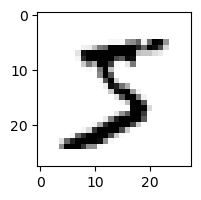

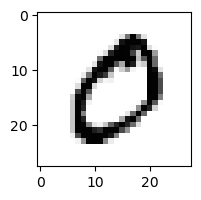

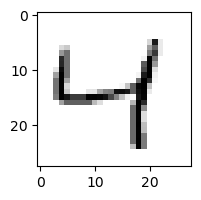

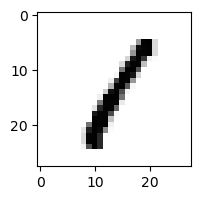

Label of train:  [5 0 4 1]


In [9]:
# 샘플 데이터 시각화
# 0에서 255 사이의 값을 가진 데이터 시각화
for i in range(4):
  plt.figure(figsize=(2,2))
  plt.imshow(X_train[i], cmap='Greys')
  plt.show()

print('Label of train: ', Y_train[:4])

In [10]:
# 데이터 스케일링
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255
print('X_train: ', X_train.shape, 'Y_train: ', Y_train.shape)
print('X_test: ', X_test.shape, 'Y_test: ', Y_test.shape)

X_train:  (60000, 28, 28) Y_train:  (60000,)
X_test:  (10000, 28, 28) Y_test:  (10000,)


In [11]:
# Reshape
X_train = X_train.reshape(X_train.shape[0], -1)   # X_trina을 2차원(0인덱스는 X_train.shape[0]으로 나머지는 1인덱스에 자동 계산)으로 변경
X_test = X_test.reshape(X_test.shape[0], -1)
print('X_train: ', X_train.shape, 'Y_train: ', Y_train.shape)
print('X_test: ', X_test.shape, 'Y_test: ', Y_test.shape)

X_train:  (60000, 784) Y_train:  (60000,)
X_test:  (10000, 784) Y_test:  (10000,)


## MLP

<img src='https://github.com/ahn283/finance/blob/main/machine_learning/img/DL_MLP_Custom.PNG?raw=true' width=500>

In [12]:
# Hyperparameter

tf.random.set_seed(1)
HIDDEN_ACTIVATION = 'relu'
OUTPUT_ACTIVATION ='softmax'
LOSS = 'sparse_categorical_crossentropy'
LEARNING_RATE = 0.01
OPTIMIZER = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
METRICS = ['accuracy']
BATCH_SIZE = 64
EPOCHS = 5
VERBOSE = 1

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


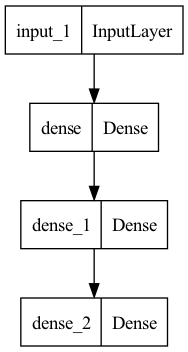

In [13]:
# Building network
inputs = Input(shape=(X_train.shape[1], ))
hiddens = Dense(256, activation=HIDDEN_ACTIVATION)(inputs)
hiddens = Dense(128, activation=HIDDEN_ACTIVATION)(hiddens)
output = Dense(10, activation=OUTPUT_ACTIVATION)(hiddens)
model = Model(inputs, output)
model.summary()
plot_model(model)

Epoch 1/5
  1/750 [..............................] - ETA: 1:47 - loss: 2.2856 - accuracy: 0.0938

2023-05-20 19:39:44.737596: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


750/750 [==============================] - 1s 2ms/step - loss: 0.2542 - accuracy: 0.9232 - val_loss: 0.1649 - val_accuracy: 0.9528
Epoch 2/5
750/750 [==============================] - 1s 1ms/step - loss: 0.1550 - accuracy: 0.9562 - val_loss: 0.1610 - val_accuracy: 0.9553
Epoch 3/5
750/750 [==============================] - 1s 1ms/step - loss: 0.1337 - accuracy: 0.9636 - val_loss: 0.1370 - val_accuracy: 0.9643
Epoch 4/5
750/750 [==============================] - 1s 2ms/step - loss: 0.1222 - accuracy: 0.9664 - val_loss: 0.1316 - val_accuracy: 0.9646
Epoch 5/5
750/750 [==============================] - 1s 1ms/step - loss: 0.1073 - accuracy: 0.9701 - val_loss: 0.1692 - val_accuracy: 0.9621


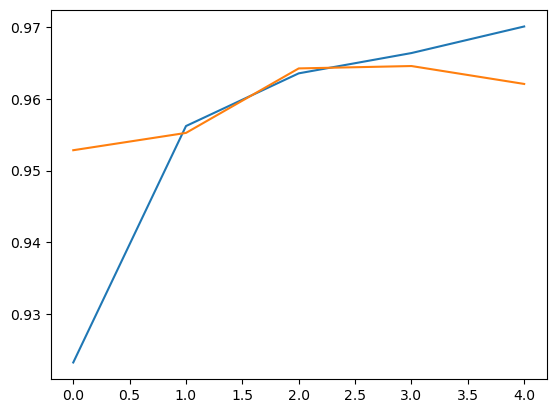

In [14]:
# 데이터 학습하기
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
model_fit = model.fit(X_train, Y_train, validation_split=0.2,
                      batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=VERBOSE)
plt.plot(pd.DataFrame(model_fit.history[METRICS[0]]))
plt.plot(pd.DataFrame(model_fit.history['val_'+METRICS[0]]))
plt.show()

### Prediction and Evaluation

In [15]:
# Train 데이터 예측하기
Y_trpred = model.predict(X_train)
print(Y_trpred, '\n\n', np.argmax(Y_trpred, axis=1))

1875/1875 [==============================] - 1s 426us/step
[[3.1437785e-27 1.8723231e-19 5.0368331e-26 ... 1.0652860e-31
  2.8558574e-18 3.9166410e-15]
 [1.0000000e+00 1.9595702e-31 1.1167094e-14 ... 4.4157179e-26
  2.3295128e-19 1.4626191e-25]
 [4.7868065e-17 1.3850577e-13 7.5091652e-12 ... 1.8156037e-12
  6.4066185e-20 1.2458509e-10]
 ...
 [1.6580794e-17 1.8164415e-20 3.2967343e-22 ... 9.5059514e-24
  8.2457305e-11 3.3489950e-11]
 [3.3979257e-11 1.5888419e-13 3.5203578e-09 ... 2.5000508e-18
  2.4961064e-10 5.4279555e-14]
 [2.6992439e-07 4.0364398e-07 6.4845489e-07 ... 2.0099424e-09
  9.9999809e-01 5.3161577e-09]] 

 [5 0 4 ... 5 6 8]


In [16]:
# Test 데이터 예측하기
Y_tepred = model.predict(X_test)
print(Y_tepred, '\n\n', np.argmax(Y_tepred, axis=1))

313/313 [==============================] - 0s 449us/step
[[3.53616916e-27 2.53311011e-10 2.25129878e-13 ... 1.00000000e+00
  1.11708010e-14 1.68450018e-08]
 [1.38453101e-26 5.72152545e-16 1.00000000e+00 ... 5.44894429e-25
  6.07655759e-25 1.44610176e-34]
 [1.00846942e-16 1.00000000e+00 1.96391392e-09 ... 1.63487821e-10
  1.98665462e-09 6.82646756e-14]
 ...
 [4.42939549e-13 1.97739429e-11 1.32234745e-09 ... 1.27060723e-10
  3.02651350e-13 1.64522532e-07]
 [8.08424201e-29 2.23792345e-25 1.42777637e-28 ... 0.00000000e+00
  9.42064088e-18 1.22674334e-26]
 [6.50282508e-14 2.81342180e-14 6.76369138e-09 ... 3.37048647e-23
  2.43266934e-10 7.90511438e-20]] 

 [7 2 1 ... 4 5 6]


In [17]:
# Train 예측 성능 평가하기
# 학습과정의 결과와 유사
model.evaluate(X_train, Y_train)

1875/1875 [==============================] - 1s 530us/step - loss: 0.1125 - accuracy: 0.9699


[0.11246228218078613, 0.9698833227157593]

In [18]:
# Train 예측 성능 평가하기
# 학습과정의 결과와 유사
pd.crosstab(Y_train, np.argmax(model.predict(X_train), axis=1),
            rownames=['True'], colnames=['Pred'])

1875/1875 [==============================] - 1s 441us/step


Pred,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,5804,0,18,0,12,0,48,0,38,3
1,0,6603,36,5,16,9,4,24,41,4
2,10,3,5888,4,4,1,0,17,28,3
3,4,0,117,5723,3,63,1,30,137,53
4,4,4,23,0,5759,0,4,6,12,30
5,2,2,15,32,12,5232,28,2,54,42
6,14,1,28,0,57,34,5763,0,21,0
7,1,12,54,0,11,3,0,6089,6,89
8,8,13,29,3,18,18,12,3,5735,12


In [19]:
# Test 예측 성능 평가하기
model.evaluate(X_test, Y_test)

313/313 [==============================] - 0s 519us/step - loss: 0.1647 - accuracy: 0.9614


[0.16472136974334717, 0.9613999724388123]

In [20]:
# Test 예측 성능 평가하기
pd.crosstab(Y_test, np.argmax(model.predict(X_test), axis=1),
            rownames=['True'], colnames=['Pred'])

313/313 [==============================] - 0s 459us/step


Pred,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,953,0,4,0,8,0,9,0,4,2
1,0,1112,5,4,0,0,2,2,10,0
2,3,0,1012,2,1,0,2,5,7,0
3,0,0,18,948,0,10,0,4,18,12
4,1,0,8,0,954,0,4,3,1,11
5,2,0,3,11,3,846,6,0,12,9
6,5,2,7,0,18,7,915,0,4,0
7,1,7,9,2,1,0,0,985,5,18
8,3,0,4,0,2,3,2,3,956,1


In [21]:
# 임의 데이터를 예측하고 정답과 비굑하기
idx_rand = np.random.randint(0, X_train.shape[0])
print('목표값: ', Y_train[idx_rand])
print('예측값: ', np.argmax(model.predict(X_train[idx_rand][np.newaxis, :])))   # 새로운 데이터 입력해서 예측시 2차원 형식으로 입력 필요 (1, 784)

목표값:  0
1/1 [==============================] - 0s 9ms/step
예측값:  4


### Summary

normalized X:  (60000, 28, 28) 0.0 1.0
normalized X:  (10000, 28, 28) 0.0 1.0
X_train: (60000, 784) Y_train: (60000,)
X_test: (10000, 784) Y_test: (10000,)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_3 (Dense)             (None, 256)               200960    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
750/750 [==============================] - 1s 2ms/step - loss: 0.2524 - accuracy: 0.9241 - val_loss: 0.1579 - val_accuracy: 0.9529
Epoch 2/5
750/750 [==============================] - 1s 1ms/step - loss: 0.1584 - accuracy: 0.9550 - val_loss: 0.1771 - val_accuracy: 0.9541
Epoch 3/5
750/750 [==============================] - 1s 1ms/step - loss: 0.1414 - accuracy: 0.9605 - val_loss: 0.2049 - val_accuracy: 0.9537
Epoch 4/5
750/750 [==============================] - 1s 1ms/step - loss: 0.1202 - accuracy: 0.9674 - val_loss: 0.1412 - val_accuracy: 0.9627
Epoch 5/5
750/750 [==============================] - 1s 1ms/step - loss: 0.1064 - accuracy: 0.9706 - val_loss: 0.1600 - val_accuracy: 0.9602


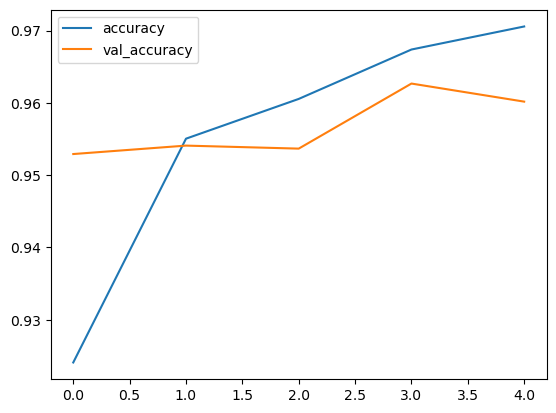

313/313 [==============================] - 0s 520us/step - loss: 0.1331 - accuracy: 0.9642

Test Confusion Maxtrix: 
313/313 [==============================] - 0s 438us/step


Pred,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,962,0,1,0,0,0,7,3,4,3
1,0,1121,1,0,0,4,0,1,8,0
2,1,0,1008,2,0,1,4,5,11,0
3,0,0,8,961,0,13,0,7,14,7
4,0,3,4,2,903,0,15,2,11,42
5,4,0,1,10,0,862,5,1,5,4
6,3,3,1,0,2,7,938,0,3,1
7,1,7,16,1,0,0,0,988,9,6
8,6,1,6,3,4,8,6,3,936,1


In [22]:
# 하이퍼파라미터
tf.random.set_seed(1)
HIDDEN_ACTIVATION = 'relu'
OUTPUT_ACTIVATION = 'softmax'
LOSS = 'sparse_categorical_crossentropy'
LEARNING_RATE = 0.01
OPTIMIZER = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
METRICS = ['accuracy']
BATCH_SIZE = 64
EPOCHS = 5
VERBOSE = 1

# Train, Test로 로딩
mnist = keras.datasets.mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# 데이터 스케일링
X_train = X_train.astype("float32")/255
X_test = X_test.astype("float32")/255
print('normalized X: ', X_train.shape, X_train.min(), X_train.max())
print('normalized X: ', X_test.shape, X_test.min(), X_test.max())

# Reshape
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# 네트워크 구축
inputs = Input(shape=(X_train.shape[1],))   
hiddens = Dense(256, activation=HIDDEN_ACTIVATION)(inputs)
hiddens = Dense(128, activation=HIDDEN_ACTIVATION)(hiddens)
output = Dense(10, activation=OUTPUT_ACTIVATION)(hiddens)  
model = Model(inputs, output)  
model.summary() 
plot_model(model) 

# 데이터 학습하기
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
model_fit = model.fit(X_train, Y_train, validation_split=0.2,
                      batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=VERBOSE)
plt.plot(pd.DataFrame(model_fit.history[METRICS[0]]))
plt.plot(pd.DataFrame(model_fit.history['val_'+METRICS[0]]))
plt.legend([METRICS[0], 'val_'+METRICS[0]])
plt.show()

# Train 예측 성능 평가하기
model.evaluate(X_train, Y_train)

# Test 예측 성능 평가하기
model.evaluate(X_test, Y_test)
print('\nTest Confusion Maxtrix: ')
pd.crosstab(Y_test, np.argmax(model.predict(X_test), axis=1),
            rownames=['True'], colnames=['Pred'])

## CNN

<img src='https://github.com/ahn283/finance/blob/main/machine_learning/img/CNN_Example.png?raw=true' width=900>

### Convolution and Pooling

<img src='https://github.com/ahn283/finance/blob/main/machine_learning/img/CNN_Process_BlackImage.png?raw=true' width=800>

- **Convolution**

In [23]:
# 임의 데이터 생성
## tensorflow에서는 pandas 데이터를 사용할 수없음
X = tf.random.normal(shape=(128,28,28,1), mean=1, stddev=1.)    # [batch size, W, H, channel]
X.shape

TensorShape([128, 28, 28, 1])

In [24]:
# 합성곱을 통과한 데이터
hiddens = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(X)
print('After Convolution: ', hiddens.shape)

After Convolution:  (128, 26, 26, 32)


In [25]:
# STRIDE 이동을 빠르게 할 경우의 데이터
hiddens = Conv2D(filters=32, kernel_size=(3,3), strides=2, activation='relu')(X)
print('After Convolution: ', hiddens.shape)

After Convolution:  (128, 13, 13, 32)


In [26]:
# 입력과 출력의 크기가 같은 데이터
hiddens = Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='same', activation='relu')(X)
print('After Convolution: ', hiddens.shape)

After Convolution:  (128, 28, 28, 32)


In [27]:
# 입력과 출력의 크기가 같은 데이터
## stride=2
hiddens = Conv2D(filters=32, kernel_size=(3,3), strides=2, padding='same', activation='relu')(X)
print('After Convolution: ', hiddens.shape)

After Convolution:  (128, 14, 14, 32)


- **Pooling**

In [28]:
# 임의 데이터 생성
X = tf.random.normal(shape=(128,28,28,1), mean=0, stddev=1.)
hiddens = Conv2D(filters=32, kernel_size=(3,3), strides=2, padding='same', activation='relu')(X)
print('After Convolution: ', hiddens.shape)

After Convolution:  (128, 14, 14, 32)


In [29]:
# Max pooling 이후의 데이터
hidden_pool = MaxPooling2D(pool_size=(2,2), strides=(2,2))(hiddens)
print('After Pooling: ', hidden_pool.shape)

After Pooling:  (128, 7, 7, 32)


In [30]:
# Max Pooling 이후의 데이터
hiddens_pool = MaxPooling2D(pool_size=(4,4), strides=(4,4))(hiddens)
print('After Pooling: ', hiddens_pool.shape)

After Pooling:  (128, 3, 3, 32)


In [31]:
# Max Pooling 이후의 데이터
hiddens_pool = MaxPooling2D(pool_size=(4,4), strides=(4,4), padding='same')(hiddens)
print('After Pooling: ', hiddens_pool.shape)

After Pooling:  (128, 4, 4, 32)


### Summary

normalized X:  (60000, 28, 28) 0.0 1.0
normalized X:  (10000, 28, 28) 0.0 1.0
X_train: (60000, 28, 28, 1) Y_train: (60000,)
X_test: (10000, 28, 28, 1) Y_test: (10000,)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 128)       1280      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 10)                250890    
                       

Epoch 1/5
750/750 [==============================] - 11s 14ms/step - loss: 0.1408 - accuracy: 0.9567 - val_loss: 0.0889 - val_accuracy: 0.9748
Epoch 2/5
750/750 [==============================] - 11s 14ms/step - loss: 0.0665 - accuracy: 0.9796 - val_loss: 0.0805 - val_accuracy: 0.9769
Epoch 3/5
750/750 [==============================] - 11s 14ms/step - loss: 0.0467 - accuracy: 0.9849 - val_loss: 0.0893 - val_accuracy: 0.9759
Epoch 4/5
750/750 [==============================] - 11s 15ms/step - loss: 0.0345 - accuracy: 0.9892 - val_loss: 0.0756 - val_accuracy: 0.9815
Epoch 5/5
750/750 [==============================] - 11s 15ms/step - loss: 0.0283 - accuracy: 0.9904 - val_loss: 0.0843 - val_accuracy: 0.9814


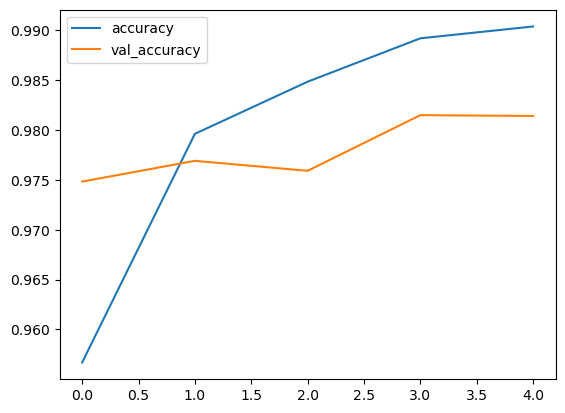

313/313 [==============================] - 1s 3ms/step - loss: 0.0722 - accuracy: 0.9831

Test Confusion Maxtrix: 
313/313 [==============================] - 1s 3ms/step


Pred,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,972,0,3,0,0,0,1,1,2,1
1,0,1127,5,0,1,0,2,0,0,0
2,2,2,1018,1,2,0,2,3,1,1
3,0,0,5,994,0,7,0,2,2,0
4,2,0,1,0,961,0,3,2,2,11
5,2,0,0,7,0,877,2,0,1,3
6,7,3,0,1,4,3,935,0,5,0
7,1,4,6,0,0,0,0,1005,3,9
8,3,0,3,0,0,1,2,3,958,4


In [32]:
# 하이퍼파라미터
tf.random.set_seed(1)
KERNEL_SIZE = (3,3)
STRIDE = 1
POOL_SIZE = (2,2)
POOL_STRIDE = 2
PADDING = 'same'
HIDDEN_ACTIVATION = 'relu'
OUTPUT_ACTIVATION = 'softmax'
LOSS = 'sparse_categorical_crossentropy'
LEARNING_RATE = 0.01
OPTIMIZER = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
METRICS = ['accuracy']
BATCH_SIZE = 64
EPOCHS = 5
VERBOSE = 1

# Train, Test로 로딩
mnist = keras.datasets.mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# 데이터 스케일링
X_train = X_train.astype("float32")/255
X_test = X_test.astype("float32")/255
print('normalized X: ', X_train.shape, X_train.min(), X_train.max())
print('normalized X: ', X_test.shape, X_test.min(), X_test.max())

# Reshape
## 3차원의 데이터로 변경 (row, width, height, depth(channel))
X_train = X_train.reshape(-1, X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(-1, X_test.shape[1], X_train.shape[2], 1)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# 네트워크 구축
## 입력값을 width: X_train.shape[1], height : X_train.shape[2], depth: X_train.depth[3]
inputs = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))   
hiddens = Conv2D(128, kernel_size=KERNEL_SIZE, strides=STRIDE, padding=PADDING, 
                 activation=HIDDEN_ACTIVATION)(inputs)
hiddens = MaxPooling2D(pool_size=POOL_SIZE, strides=POOL_STRIDE)(hiddens)
## 1차원 데이터로 변경
hiddens = Flatten()(hiddens)
output = Dense(10, activation=OUTPUT_ACTIVATION)(hiddens)  
model = Model(inputs, output)  
model.summary() 
plot_model(model) 

# 데이터 학습하기
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
model_fit = model.fit(X_train, Y_train, validation_split=0.2,
                      batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=VERBOSE)
plt.plot(pd.DataFrame(model_fit.history[METRICS[0]]))
plt.plot(pd.DataFrame(model_fit.history['val_'+METRICS[0]]))
plt.legend([METRICS[0], 'val_'+METRICS[0]])
plt.show()

# Train 예측 성능 평가하기
model.evaluate(X_train, Y_train)

# Test 예측 성능 평가하기
model.evaluate(X_test, Y_test)
print('\nTest Confusion Maxtrix: ')
pd.crosstab(Y_test, np.argmax(model.predict(X_test), axis=1),
            rownames=['True'], colnames=['Pred'])

## CNN with Tuning

normalized X:  (60000, 28, 28) 0.0 1.0
normalized X:  (10000, 28, 28) 0.0 1.0
X_train: (60000, 28, 28, 1) Y_train: (60000,)
X_test: (10000, 28, 28, 1) Y_test: (10000,)
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 128)       1280      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 14, 14, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 64)        73792     
                       

Training:   0%|           0/5 ETA: ?s,  ?epochs/s

Epoch 1/5
749/750 [============================>.] - ETA: 0s - loss: 0.4590 - accuracy: 0.8511

Training:  20%|██         1/5 ETA: 02:04s,  31.19s/epochs

750/750 [==============================] - 31s 41ms/step - loss: 0.4588 - accuracy: 0.8512 - val_loss: 0.1126 - val_accuracy: 0.9681
Epoch 2/5
749/750 [============================>.] - ETA: 0s - loss: 0.2581 - accuracy: 0.9225

Training:  40%|████       2/5 ETA: 01:33s,  31.10s/epochs

750/750 [==============================] - 31s 41ms/step - loss: 0.2584 - accuracy: 0.9225 - val_loss: 0.0903 - val_accuracy: 0.9726
Epoch 3/5
750/750 [==============================] - ETA: 0s - loss: 0.2320 - accuracy: 0.9302

Training:  60%|██████     3/5 ETA: 01:02s,  31.17s/epochs

750/750 [==============================] - 31s 42ms/step - loss: 0.2320 - accuracy: 0.9302 - val_loss: 0.0775 - val_accuracy: 0.9793
Epoch 4/5
749/750 [============================>.] - ETA: 0s - loss: 0.2215 - accuracy: 0.9332

Training:  80%|████████   4/5 ETA: 00:30s,  30.59s/epochs

750/750 [==============================] - 30s 40ms/step - loss: 0.2216 - accuracy: 0.9332 - val_loss: 0.0687 - val_accuracy: 0.9787
Epoch 5/5
749/750 [============================>.] - ETA: 0s - loss: 0.2106 - accuracy: 0.9369

Training: 100%|██████████ 5/5 ETA: 00:00s,  30.26s/epochs

750/750 [==============================] - 30s 40ms/step - loss: 0.2106 - accuracy: 0.9368 - val_loss: 0.0732 - val_accuracy: 0.9781


Training: 100%|██████████ 5/5 ETA: 00:00s,  30.57s/epochs


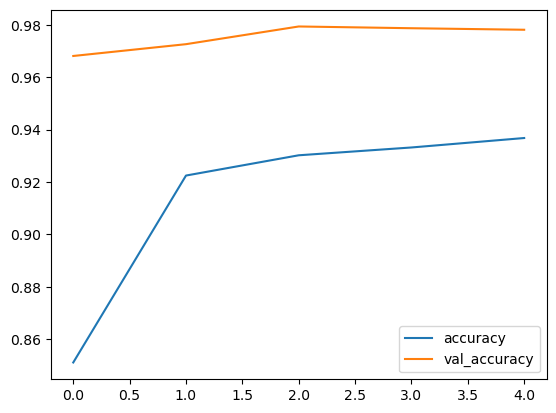

313/313 [==============================] - 2s 6ms/step - loss: 0.0684 - accuracy: 0.9793

Test Confusion Maxtrix: 
313/313 [==============================] - 2s 5ms/step


Pred,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,970,0,2,0,0,0,5,1,2,0
1,0,1124,7,1,0,0,1,1,1,0
2,3,1,1015,0,0,0,0,6,7,0
3,0,0,8,986,0,4,0,2,8,2
4,0,0,2,0,962,0,0,1,2,15
5,1,0,0,6,0,871,4,1,3,6
6,5,1,2,0,5,1,942,0,2,0
7,0,3,14,2,1,0,0,1002,2,4
8,10,2,6,0,1,3,3,3,939,7


In [33]:
# 하이퍼파라미터
tf.random.set_seed(1)
KERNEL_SIZE = (3,3)
STRIDE = 1
POOL_SIZE = (2,2)
POOL_STRIDE = 2
PADDING = 'same'
HIDDEN_ACTIVATION = 'relu'
OUTPUT_ACTIVATION = 'softmax'
DROPOUT_RATIO = 0.25
LOSS = 'sparse_categorical_crossentropy'
LEARNING_RATE = 0.01
OPTIMIZER = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
METRICS = ['accuracy']
BATCH_SIZE = 64
EPOCHS = 5
VERBOSE = 1
################
EARLYSTOP_PATIENT = 10
MONITOR = 'val_loss'
FILENAME = os.path.join(os.getcwd(),'Model','Number_MNIST_CNN.h5')
CALLBACK = [callbacks.EarlyStopping(monitor=MONITOR, mode='min', 
                                    patience=EARLYSTOP_PATIENT, verbose=1),
            tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
            callbacks.ModelCheckpoint(monitor=MONITOR, mode='min', save_best_only=True, 
                                      filepath=FILENAME)]
################

# Train, Test로 로딩
mnist = keras.datasets.mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# 데이터 스케일링
X_train = X_train.astype("float32")/255
X_test = X_test.astype("float32")/255
print('normalized X: ', X_train.shape, X_train.min(), X_train.max())
print('normalized X: ', X_test.shape, X_test.min(), X_test.max())

# Reshape
X_train = X_train.reshape(-1, X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(-1, X_test.shape[1], X_train.shape[2], 1)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# 네트워크 구축
inputs = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))   
hiddens = Conv2D(128, kernel_size=KERNEL_SIZE, strides=STRIDE, padding=PADDING, 
                 activation=HIDDEN_ACTIVATION)(inputs)
hiddens = MaxPooling2D(pool_size=POOL_SIZE, strides=POOL_STRIDE)(hiddens)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
hiddens = Conv2D(64, kernel_size=KERNEL_SIZE, strides=STRIDE, padding=PADDING, 
                 activation=HIDDEN_ACTIVATION)(hiddens)
hiddens = MaxPooling2D(pool_size=POOL_SIZE, strides=POOL_STRIDE)(hiddens)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
hiddens = Flatten()(hiddens)
hiddens = Dense(32, activation=HIDDEN_ACTIVATION)(hiddens)  
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
output = Dense(10, activation=OUTPUT_ACTIVATION)(hiddens)  
model = Model(inputs, output)  
model.summary() 
plot_model(model) 

# 데이터 학습하기
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
model_fit = model.fit(X_train, Y_train, validation_split=0.2,
                      batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=VERBOSE,
                      callbacks=CALLBACK)
plt.plot(pd.DataFrame(model_fit.history[METRICS[0]]))
plt.plot(pd.DataFrame(model_fit.history['val_'+METRICS[0]]))
plt.legend([METRICS[0], 'val_'+METRICS[0]])
plt.show()

# Train 예측 성능 평가하기
model.evaluate(X_train, Y_train)

# Test 예측 성능 평가하기
model.evaluate(X_test, Y_test)
print('\nTest Confusion Maxtrix: ')
pd.crosstab(Y_test, np.argmax(model.predict(X_test), axis=1),
            rownames=['True'], colnames=['Pred'])

목표값: 


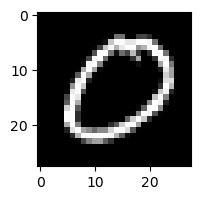

1/1 [==============================] - 0s 10ms/step
예측값:  0


In [34]:
# 임의 데이터를 예측하고 정답과 비교하기
idx_rand = np.random.randint(0, X_test.shape[0])
print('목표값: ')
plt.figure(figsize=(2,2))
plt.imshow(X_test[idx_rand], cmap='gray')
plt.show()
print('예측값: ', np.argmax(model.predict(X_test[idx_rand][np.newaxis,:])))

# **Problem:** 패션이미지 분류

## Data Preprocessing

In [35]:
# Train, Test 로딩
mnist = keras.datasets.fashion_mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [36]:
# 데이터의 갯수와 크기 확인
print('---------------train----------------')
print('X: ', X_train.shape, X_train.min(), X_train.max())
print('Y: ', Y_train.shape)
print('----------------test----------------')
print('X: ', X_test.shape, X_test.min(), X_test.max())
print('Y: ', Y_test.shape)

---------------train----------------
X:  (60000, 28, 28) 0 255
Y:  (60000,)
----------------test----------------
X:  (10000, 28, 28) 0 255
Y:  (10000,)


In [37]:
# 샘플 데이터 출력
# 0에서 255 사이의 값을 가진 데이터
for i in range(X_train[0].shape[0]):
    for j in range(X_train[0].shape[1]):
        print('{:4d}'.format(X_train[0][i][j]), end='')
    print()

   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0   0   1   4   0   0   0   0   1   1   0
   0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62  54   0   0   0   1   3   4   0   0   3
   0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134 144 123  23   0   0   0   0  12  10   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178 107 156 161 109  64  23  77 130  72  15
   0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216 216 163 127 121 122 146 141  88 172  66
   0   0   0   0   0   0   0   0   0   1   1   1   0 200 232 232 233 229 223 223 215 213 164 127

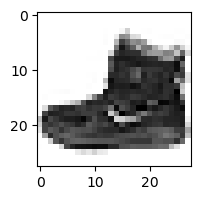

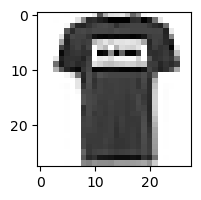

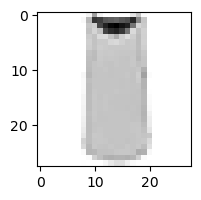

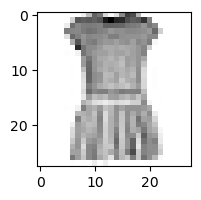

Label of train:  ['Ankle Boot', 'T-shirt', 'T-shirt', 'Dress']


In [38]:
# 샘플 데이터 시각화
# 0에서 255 사이의 값을 가진 데이터 시각화
for i in range(4):
  plt.figure(figsize=(2,2))
  plt.imshow(X_train[i], cmap='Greys')
  plt.show()
Y_label_list = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']
print('Label of train: ', [Y_label_list[num] for num in Y_train[:4]])

## `categorical_crossentropy?`

**"일반적으로 다중 클래스/라벨 분류시, `categorical_crossentropy` 또는 `sparse_categorical_crossentropy`를 사용할 수 있음"**

- 숫자이미지 데이터의 Y값은 `0에서 9사이의 값이 출력될 1자리의 숫자`

```python
---------------train----------------
X:  (60000, 28, 28) 0 255
Y:  (60000,)
----------------test----------------
X:  (10000, 28, 28) 0 255
Y:  (10000,)
```

- 모델링의 출력형태는 `0에서 9사이의 값이 출력될 각각의 확률 10자리의 숫자`

```python
output = Dense(10, activation=OUTPUT_ACTIVATION)(hiddens) 
```

In [39]:
# sparse_categorical_crossentropy 사용시 입출력
# Y값은 0에서 2사이의 값이 출력될 1자리의 숫자 2개 레이블
Y_true = [1, 2]

# 출력 Y는 0에서 2사이의 값이 출력될 각각의 확률 3자리의 숫자
## 첫번째 list [0일 확률, 1일 확률, 2일 확률], 두번째 list [0일 확률, 1일 확률, 2일 확률]
Y_pred = [[0, 0.9, 0.1], [0.6, 0.8, 0.1]]
loss = keras.metrics.sparse_categorical_crossentropy(Y_true, Y_pred)

## loss : 첫번째 정답과 확률, 두번째 정답과 확률 비교 계산
## numpy=array([0.10536056, 2.7080503 ], dtype=float32)
loss

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.10536056, 2.7080503 ], dtype=float32)>

```python
# Y값은 0에서 2사이의 값이 출력될 각각의 확률 3자리의 숫자로(One-hot Encoding 방식)으로 받을 시 출력
Y_true = [[0,1,0], [0,0,1]]
# 출력 Y는 0에서 2사이의 값이 출력될 각각의 확률 3자리의 숫자
Y_pred = [[0, 0.9, 0.1], [0.6, 0.8, 0.1]]
loss = keras.metrics.sparse_categorical_crossentropy(Y_true, Y_pred)
loss

- sparse_categorical_crossentropy를 쓰려면 입력값은 한자리(hot hot encoding이 아니어야 함)여야 하며, 출력값은 클래스 갯수 만큼 있여야 함

# 출력 메시지
---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
~\AppData\Local\Temp\ipykernel_22364\934507019.py in <module>
      1 Y_true = [[0,1,0], [1,0,1]]
      2 Y_pred = [[0, 0.9, 0.1], [0.7, 0.8, 0.1]]
----> 3 loss = keras.metrics.sparse_categorical_crossentropy(Y_true, Y_pred)
      4 loss.shape

~\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\util\traceback_utils.py in error_handler(*args, **kwargs)
    151     except Exception as e:
    152       filtered_tb = _process_traceback_frames(e.__traceback__)
--> 153       raise e.with_traceback(filtered_tb) from None
    154     finally:
    155       del filtered_tb

~\anaconda3\lib\site-packages\keras\losses.py in sparse_categorical_crossentropy(y_true, y_pred, from_logits, axis, ignore_class)
   2082       Sparse categorical crossentropy loss value.
   2083     """
-> 2084     return backend.sparse_categorical_crossentropy(
   2085         y_true,
   2086         y_pred,

~\anaconda3\lib\site-packages\keras\backend.py in sparse_categorical_crossentropy(target, output, from_logits, axis, ignore_class)
   5632             )
   5633     else:
-> 5634         res = tf.nn.sparse_softmax_cross_entropy_with_logits(
   5635             labels=target, logits=output
   5636         )

ValueError: `labels.shape` must equal `logits.shape` except for the last dimension. Received: labels.shape=(6,) and logits.shape=(2, 3)
```

In [40]:
# Y값은 0에서 2사이의 값이 출력될 각각의 확률 3자리의 숫자로(One-hot Encoding 방식)으로 받을 시 출력
Y_true = [[0,1,0], [0,0,1]]
# 출력 Y는 0에서 2사이의 값이 출력될 각각의 확률 3자리의 숫자
Y_pred = [[0, 0.9, 0.1], [0.6, 0.8, 0.1]]
loss = keras.metrics.categorical_crossentropy(Y_true, Y_pred)
loss

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.10536054, 2.7080503 ], dtype=float32)>

| **다중분류 비용함수 종류** | **Y 입력형태** | **Y 출력형태** | **결론** |
|:-----:|:-----:|:-----:|:-----:|
| `sparse_categorical_crossentropy` | `[1, 2]` | `[[0, 0.9, 0.1], [0.6, 0.8, 0.1]]` | 입력이 `정수형태`일 때 사용 |
| `categorical_crossentropy` | `[[0,1,0], [0,0,1]]` | `[[0, 0.9, 0.1], [0.6, 0.8, 0.1]]` | 입력이 `One-hot 벡터형태`일 때 사용 |

- 어떤 비용함수를 사용하든 `정확성 성능은 동일`하지만, `sparse_categorical_crossentropy`를 사용하면 One-hot Encoding을 사용하지 않기 때문에 `메모리를 적게 사용하는 이점`

## `One-hot Encoding?`

**1) Binning(구간화):** `연속형 변수를 범주형` 변수로 변환

- 숫자로 구성된 `연속형 값이 넓을 경우` 그룹을 지어 이해도를 높임

- 변수의 선형적 특성 이외에 `비선형적 특성을 반영`

**2) Label Encoding:** `범주형 변수`의 값들을 `숫자 값(레이블)`로 변경

<img src='https://github.com/ahn283/finance/blob/main/time_series/img/Label_Encoding.png?raw=true' width=250>

**3) Dummy Variable(가변수, $D_i$)**: `범주형 변수`를 `0 또는 1값`을 가진 `하나 이상의 새로운 변수`로 변경(One-hot Encoding)

**생성법:** `계절변수`가 봄/여름/가을/겨울 이라는 값을 포함하는 경우, `계절_봄`, `계절_여름`, `계절_가을`, `계절_겨울` 총 4개의 변수를 생성

(1) 범주형 변수의 `독립 값을 확인` (봄/여름/가을/겨울)

(2) 독립 값의 `갯수만큼 더미변수`를 생성 ($D_1$ = 봄, $D_2$ = 여름, $D_3$ = 가을, $D_3$ = 겨울) 

  - *더미변수의 갯수는 최대 1개까지 줄일 수 있음*

(3) 각 `더미변수들의 값`은 변수의 정의와 `같으면 1`이고 `나머지는 0`으로 채움   

<img src='https://github.com/ahn283/finance/blob/main/time_series/img/Dummy_Engineering.png?raw=true' width=500>

## MLP

<img src='https://github.com/ahn283/finance/blob/main/deep_learning/img/DL_MLP_Custom.PNG?raw=true' width=500>

normalized X:  (60000, 28, 28) 0.0 1.0
normalized X:  (10000, 28, 28) 0.0 0.0
X_train:  (60000, 784) Y_train:  (60000, 10)
X_test:  (10000, 784) Y_test:  (10000, 10)
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_9 (Dense)             (None, 256)               200960    
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dense_11 (Dense)            (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
750/750 [==============================] - 1s 1ms/step - loss: 0.5450 - accuracy: 0.8064 - val_loss: 0.4416 - val_accuracy: 0.8384
Epoch 2/10
750/750 [==============================] - 1s 2ms/step - loss: 0.4148 - accuracy: 0.8501 - val_loss: 0.4700 - val_accuracy: 0.8365
Epoch 3/10
750/750 [==============================] - 1s 1ms/step - loss: 0.3872 - accuracy: 0.8590 - val_loss: 0.4829 - val_accuracy: 0.8343
Epoch 4/10
750/750 [==============================] - 1s 1ms/step - loss: 0.3814 - accuracy: 0.8630 - val_loss: 0.4010 - val_accuracy: 0.8632
Epoch 5/10
750/750 [==============================] - 1s 1ms/step - loss: 0.3651 - accuracy: 0.8695 - val_loss: 0.4480 - val_accuracy: 0.8411
Epoch 6/10
750/750 [==============================] - 1s 1ms/step - loss: 0.3558 - accuracy: 0.8728 - val_loss: 0.3838 - val_accuracy: 0.8664
Epoch 7/10
750/750 [==============================] - 1s 1ms/step - loss: 0.3496 - accuracy: 0.8756 - val_loss: 0.4138 - val_accuracy: 0.8630
Epoch 

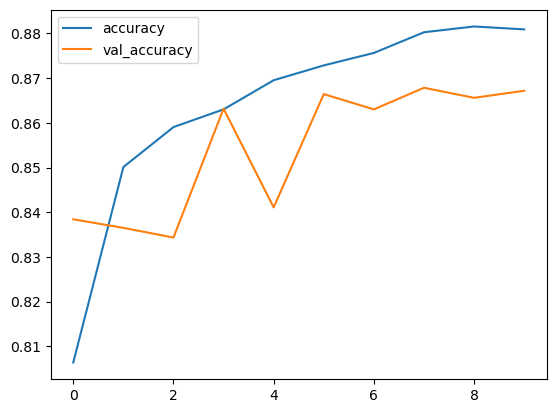

313/313 [==============================] - 0s 530us/step - loss: 0.4144 - accuracy: 0.8588

Test Confusion Matrix: 
313/313 [==============================] - 0s 457us/step


Pred,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,820,7,16,50,10,2,85,0,10,0
1,1,969,0,20,3,1,3,0,2,1
2,8,4,659,11,248,1,68,0,1,0
3,22,14,9,855,75,4,16,0,5,0
4,0,0,46,20,894,0,39,0,1,0
5,0,0,0,0,0,975,0,16,0,9
6,154,2,73,42,124,1,593,0,11,0
7,0,0,0,0,0,54,0,926,0,20
8,2,0,2,9,6,14,10,2,955,0


In [41]:
# Hyperparameters
tf.random.set_seed(1)
KERNEL_SIZE = (3, 3)
STRIDE = 1
POOL_SIZE = (2, 2)
POOL_STRIDE = 2
PADDING = 'same'
HIDDEN_ACTIVATION = 'relu'
OUTPUT_ACTIVATION = 'softmax'
DROPOUT_RATIO = 0.25
LOSS = 'categorical_crossentropy'
LEARNING_RATE = 0.01
OPTIMIZER = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
METRICS = ['accuracy']
BATCH_SIZE = 64
EPOCHS = 10
VERBOSE = 1
##########
EARLYSTOP_PATIENT = 10
MONITOR = 'val_loss'
FILENAME = os.path.join(os.getcwd(), 'Model', 'Fashion_MNIST_MLP.h5')
CALLBACK = [callbacks.EarlyStopping(monitor=MONITOR, mode='min',
                                    patience=EARLYSTOP_PATIENT, verbose=VERBOSE),
            tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
            callbacks.ModelCheckpoint(monitor=MONITOR, mode='min', save_best_only=True,
                                      filepath=FILENAME)]
#########

# train, test 로딩
mnist = keras.datasets.fashion_mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# 데이터 스케일
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255
print('normalized X: ', X_train.shape, X_train.min(), X_train.max())
print('normalized X: ', X_test.shape, X_test.min(), X_test.min())

# Reshape
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
Y_train = np_utils.to_categorical(Y_train)
Y_test = np_utils.to_categorical(Y_test)
print('X_train: ', X_train.shape, 'Y_train: ', Y_train.shape)
print('X_test: ', X_test.shape, 'Y_test: ', Y_test.shape)

# Building network
inputs = Input(shape=(X_train.shape[1],))   # scala가 아니고 vector 이기 때문에 (X_train[1], ) 형태
hiddens = Dense(256, activation=HIDDEN_ACTIVATION)(inputs)
hiddens = Dense(128, activation=HIDDEN_ACTIVATION)(hiddens)
output = Dense(10, activation=OUTPUT_ACTIVATION)(hiddens)
model = Model(inputs, output)
model.summary()
plot_model(model)

# fit dataset
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
model_fit = model.fit(X_train, Y_train, validation_split=0.2,
                      batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=VERBOSE)
plt.plot(pd.DataFrame(model_fit.history[METRICS[0]]))
plt.plot(pd.DataFrame(model_fit.history['val_'+METRICS[0]]))
plt.legend([METRICS[0], 'val_'+METRICS[0]])
plt.show()

# Train 예측 성능 평가하기
model.evaluate(X_train, Y_train)

# Test 예측 성능 평가하기
model.evaluate(X_test, Y_test)
print('\nTest Confusion Matrix: ')
pd.crosstab(np.argmax(Y_test, axis=1), np.argmax(model.predict(X_test), axis=1),
            rownames=['True'], colnames=['Pred'])

## CNN

<img src='https://github.com/ahn283/finance/blob/main/machine_learning/img/CNN_Example.png?raw=true' width=900>

normalized X:  (60000, 28, 28) 0.0 1.0
normalized X:  (10000, 28, 28) 0.0 1.0
X_train: (60000, 28, 28, 1) Y_train: (60000, 10)
X_test: (10000, 28, 28, 1) Y_test: (10000, 10)
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 128)       1280      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 128)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 64)        73792     
                 

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10
750/750 [==============================] - ETA: 0s - loss: 0.6466 - accuracy: 0.7606

Training:  10%|█          1/10 ETA: 04:19s,  28.84s/epochs

750/750 [==============================] - 29s 38ms/step - loss: 0.6466 - accuracy: 0.7606 - val_loss: 0.3845 - val_accuracy: 0.8620
Epoch 2/10
749/750 [============================>.] - ETA: 0s - loss: 0.5005 - accuracy: 0.8168

Training:  20%|██         2/10 ETA: 03:51s,  28.90s/epochs

750/750 [==============================] - 29s 39ms/step - loss: 0.5002 - accuracy: 0.8169 - val_loss: 0.3765 - val_accuracy: 0.8668
Epoch 3/10
750/750 [==============================] - ETA: 0s - loss: 0.4653 - accuracy: 0.8317

Training:  30%|███        3/10 ETA: 03:22s,  28.90s/epochs

750/750 [==============================] - 29s 39ms/step - loss: 0.4653 - accuracy: 0.8317 - val_loss: 0.3636 - val_accuracy: 0.8658
Epoch 4/10
749/750 [============================>.] - ETA: 0s - loss: 0.4504 - accuracy: 0.8339

Training:  40%|████       4/10 ETA: 02:53s,  28.96s/epochs

750/750 [==============================] - 29s 39ms/step - loss: 0.4507 - accuracy: 0.8338 - val_loss: 0.3331 - val_accuracy: 0.8777
Epoch 5/10
749/750 [============================>.] - ETA: 0s - loss: 0.4413 - accuracy: 0.8374

Training:  50%|█████      5/10 ETA: 02:24s,  28.83s/epochs

750/750 [==============================] - 29s 38ms/step - loss: 0.4413 - accuracy: 0.8375 - val_loss: 0.3670 - val_accuracy: 0.8603
Epoch 6/10
749/750 [============================>.] - ETA: 0s - loss: 0.4396 - accuracy: 0.8390

Training:  60%|██████     6/10 ETA: 01:56s,  29.00s/epochs

750/750 [==============================] - 29s 39ms/step - loss: 0.4397 - accuracy: 0.8389 - val_loss: 0.3180 - val_accuracy: 0.8823
Epoch 7/10
750/750 [==============================] - ETA: 0s - loss: 0.4366 - accuracy: 0.8391

Training:  70%|███████    7/10 ETA: 01:26s,  28.87s/epochs

750/750 [==============================] - 29s 38ms/step - loss: 0.4366 - accuracy: 0.8391 - val_loss: 0.3308 - val_accuracy: 0.8754
Epoch 8/10
750/750 [==============================] - ETA: 0s - loss: 0.4306 - accuracy: 0.8415

Training:  80%|████████   8/10 ETA: 00:57s,  28.80s/epochs

750/750 [==============================] - 29s 38ms/step - loss: 0.4306 - accuracy: 0.8415 - val_loss: 0.3116 - val_accuracy: 0.8804
Epoch 9/10
749/750 [============================>.] - ETA: 0s - loss: 0.4230 - accuracy: 0.8426

Training:  90%|█████████  9/10 ETA: 00:28s,  28.81s/epochs

750/750 [==============================] - 29s 38ms/step - loss: 0.4232 - accuracy: 0.8425 - val_loss: 0.3155 - val_accuracy: 0.8827
Epoch 10/10
750/750 [==============================] - ETA: 0s - loss: 0.4221 - accuracy: 0.8438

Training: 100%|██████████ 10/10 ETA: 00:00s,  28.83s/epochs

750/750 [==============================] - 29s 39ms/step - loss: 0.4221 - accuracy: 0.8438 - val_loss: 0.3255 - val_accuracy: 0.8807


Training: 100%|██████████ 10/10 ETA: 00:00s,  28.86s/epochs


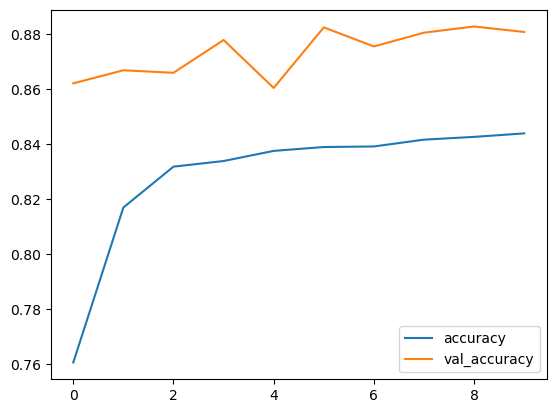

313/313 [==============================] - 2s 6ms/step - loss: 0.3470 - accuracy: 0.8722

Test Confusion Maxtrix: 
313/313 [==============================] - 2s 6ms/step


Pred,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,841,0,26,35,7,1,84,0,6,0
1,1,981,0,10,5,0,2,0,1,0
2,8,1,746,6,193,0,46,0,0,0
3,18,7,9,865,56,0,45,0,0,0
4,0,0,54,24,864,0,58,0,0,0
5,0,0,0,0,0,945,0,44,1,10
6,156,3,101,27,105,0,598,0,10,0
7,0,0,0,0,0,3,0,990,0,7
8,0,1,9,4,8,1,6,6,965,0


In [42]:
# 하이퍼파라미터
tf.random.set_seed(1)
KERNEL_SIZE = (3,3)
STRIDE = 1
POOL_SIZE = (2,2)
POOL_STRIDE = 2
PADDING = 'same'
HIDDEN_ACTIVATION = 'relu'
OUTPUT_ACTIVATION = 'softmax'
DROPOUT_RATIO = 0.25
LOSS = 'categorical_crossentropy'
LEARNING_RATE = 0.01
OPTIMIZER = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
METRICS = ['accuracy']
BATCH_SIZE = 64
EPOCHS = 10
VERBOSE = 1
################
EARLYSTOP_PATIENT = 10
MONITOR = 'val_loss'
FILENAME = os.path.join(os.getcwd(),'Model','Fashion_MNIST_CNN.h5')
CALLBACK = [callbacks.EarlyStopping(monitor=MONITOR, mode='min', 
                                    patience=EARLYSTOP_PATIENT, verbose=1),
            tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
            callbacks.ModelCheckpoint(monitor=MONITOR, mode='min', save_best_only=True, 
                                      filepath=FILENAME)]
################

# Train, Test로 로딩
mnist = keras.datasets.fashion_mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# 데이터 스케일링
X_train = X_train.astype("float32")/255
X_test = X_test.astype("float32")/255
print('normalized X: ', X_train.shape, X_train.min(), X_train.max())
print('normalized X: ', X_test.shape, X_test.min(), X_test.max())

# Reshape
X_train = X_train.reshape(-1, X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(-1, X_test.shape[1], X_train.shape[2], 1)
## cross_entropy Loss를 쓰기 위해서는 Y도 갯수만큼 필요
## to_cateogirucal 10자리로 변경
Y_train = np_utils.to_categorical(Y_train)
Y_test = np_utils.to_categorical(Y_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# 네트워크 구축
inputs = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))   
hiddens = Conv2D(128, kernel_size=KERNEL_SIZE, strides=STRIDE, padding=PADDING, 
                 activation=HIDDEN_ACTIVATION)(inputs)
hiddens = MaxPooling2D(pool_size=POOL_SIZE, strides=POOL_STRIDE)(hiddens)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
hiddens = Conv2D(64, kernel_size=KERNEL_SIZE, strides=STRIDE, padding=PADDING, 
                 activation=HIDDEN_ACTIVATION)(hiddens)
hiddens = MaxPooling2D(pool_size=POOL_SIZE, strides=POOL_STRIDE)(hiddens)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
hiddens = Flatten()(hiddens)
hiddens = Dense(32, activation=HIDDEN_ACTIVATION)(hiddens)  
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
output = Dense(10, activation=OUTPUT_ACTIVATION)(hiddens)  
model = Model(inputs, output)  
model.summary() 
plot_model(model) 

# 데이터 학습하기
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
model_fit = model.fit(X_train, Y_train, validation_split=0.2,
                      batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=VERBOSE,
                      callbacks=CALLBACK)
plt.plot(pd.DataFrame(model_fit.history[METRICS[0]]))
plt.plot(pd.DataFrame(model_fit.history['val_'+METRICS[0]]))
plt.legend([METRICS[0], 'val_'+METRICS[0]])
plt.show()

# Train 예측 성능 평가하기
model.evaluate(X_train, Y_train)

# Test 예측 성능 평가하기
model.evaluate(X_test, Y_test)
print('\nTest Confusion Maxtrix: ')
pd.crosstab(np.argmax(Y_test, axis=1), np.argmax(model.predict(X_test), axis=1),
            rownames=['True'], colnames=['Pred'])

목표값: 


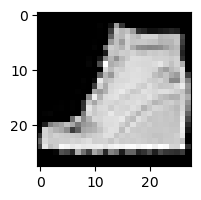

1/1 [==============================] - 0s 29ms/step
예측값:  Ankle Boot


In [43]:
# 베스트 모델 로딩
model = load_model(FILENAME)

# 임의 데이터를 예측하고 정답과 비교하기
idx_rand = np.random.randint(0, X_test.shape[0])
print('목표값: ')
plt.figure(figsize=(2,2))
plt.imshow(X_test[idx_rand], cmap='gray')
plt.show()
Y_label_list = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']
print('예측값: ', Y_label_list[np.argmax(model.predict(X_test[idx_rand][np.newaxis,:]))])

## ResNet50

<img src='https://github.com/ahn283/finance/blob/main/machine_learning/img/CNN_ResNet.png?raw=true' width=1000>

normalized X:  (60000, 28, 28) 0.0 1.0
normalized X:  (10000, 28, 28) 0.0 1.0
X_train: (60000, 28, 28, 1) Y_train: (60000, 10)
X_test: (10000, 28, 28, 1) Y_test: (10000, 10)
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 34, 34, 1)    0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 14, 14, 64)   3200        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (Batch

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10
750/750 [==============================] - ETA: 0s - loss: 1.0320 - accuracy: 0.6767

Training:  10%|█          1/10 ETA: 1:05:41s,  437.97s/epochs

750/750 [==============================] - 438s 582ms/step - loss: 1.0320 - accuracy: 0.6767 - val_loss: 0.4799 - val_accuracy: 0.8260
Epoch 2/10
750/750 [==============================] - ETA: 0s - loss: 0.6638 - accuracy: 0.7724

Training:  20%|██         2/10 ETA: 1:00:23s,  453.00s/epochs

750/750 [==============================] - 463s 618ms/step - loss: 0.6638 - accuracy: 0.7724 - val_loss: 35.2450 - val_accuracy: 0.4848
Epoch 3/10
750/750 [==============================] - ETA: 0s - loss: 0.6775 - accuracy: 0.7648

Training:  30%|███        3/10 ETA: 52:36s,  450.98s/epochs  

750/750 [==============================] - 449s 598ms/step - loss: 0.6775 - accuracy: 0.7648 - val_loss: 0.5072 - val_accuracy: 0.8123
Epoch 4/10
750/750 [==============================] - ETA: 0s - loss: 0.4811 - accuracy: 0.8311

Training:  40%|████       4/10 ETA: 45:38s,  456.37s/epochs

750/750 [==============================] - 465s 620ms/step - loss: 0.4811 - accuracy: 0.8311 - val_loss: 0.4523 - val_accuracy: 0.8382
Epoch 5/10
750/750 [==============================] - ETA: 0s - loss: 0.3814 - accuracy: 0.8615

Training:  50%|█████      5/10 ETA: 37:48s,  453.72s/epochs

750/750 [==============================] - 449s 599ms/step - loss: 0.3814 - accuracy: 0.8615 - val_loss: 0.4476 - val_accuracy: 0.8353
Epoch 6/10
750/750 [==============================] - ETA: 0s - loss: 0.3525 - accuracy: 0.8735

Training:  60%|██████     6/10 ETA: 30:04s,  451.13s/epochs

750/750 [==============================] - 446s 595ms/step - loss: 0.3525 - accuracy: 0.8735 - val_loss: 0.3677 - val_accuracy: 0.8663
Epoch 7/10
750/750 [==============================] - ETA: 0s - loss: 0.3351 - accuracy: 0.8786

Training:  70%|███████    7/10 ETA: 22:24s,  448.27s/epochs

750/750 [==============================] - 442s 589ms/step - loss: 0.3351 - accuracy: 0.8786 - val_loss: 0.3711 - val_accuracy: 0.8649
Epoch 8/10
750/750 [==============================] - ETA: 0s - loss: 0.3186 - accuracy: 0.8837

Training:  80%|████████   8/10 ETA: 14:51s,  445.91s/epochs

750/750 [==============================] - 441s 588ms/step - loss: 0.3186 - accuracy: 0.8837 - val_loss: 0.3578 - val_accuracy: 0.8721
Epoch 9/10
750/750 [==============================] - ETA: 0s - loss: 0.2932 - accuracy: 0.8935

Training:  90%|█████████  9/10 ETA: 07:28s,  448.40s/epochs

750/750 [==============================] - 454s 605ms/step - loss: 0.2932 - accuracy: 0.8935 - val_loss: 0.2987 - val_accuracy: 0.8920
Epoch 10/10
750/750 [==============================] - ETA: 0s - loss: 0.2881 - accuracy: 0.8935

Training: 100%|██████████ 10/10 ETA: 00:00s,  452.83s/epochs

750/750 [==============================] - 462s 617ms/step - loss: 0.2881 - accuracy: 0.8935 - val_loss: 0.3375 - val_accuracy: 0.8742


Training: 100%|██████████ 10/10 ETA: 00:00s,  450.97s/epochs


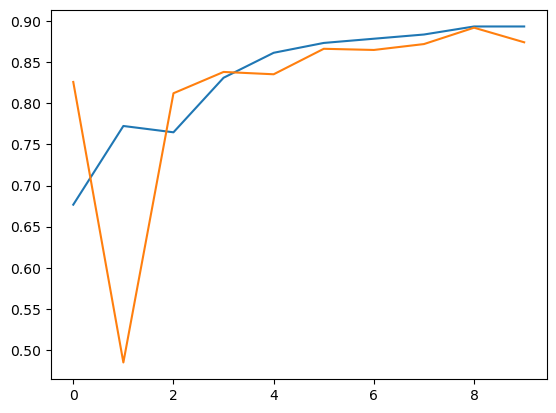

313/313 [==============================] - 12s 39ms/step - loss: 0.3559 - accuracy: 0.8670

Test Confusion Maxtrix: 
313/313 [==============================] - 12s 37ms/step


Pred,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,724,5,8,41,10,1,206,0,5,0
1,1,979,0,15,3,0,0,0,2,0
2,14,4,605,9,258,0,103,0,7,0
3,6,8,1,868,77,0,33,0,7,0
4,0,1,17,11,908,0,59,0,4,0
5,0,0,0,0,0,967,0,13,0,20
6,82,2,33,37,97,0,738,0,11,0
7,0,0,0,0,0,20,0,969,0,11
8,5,4,0,1,6,2,7,4,971,0


In [44]:
# Hyperparameters
tf.random.set_seed(1)
KERNEL_SIZE = (3, 3)
STRIDE = 1
POOL_SIZE = (2, 2)
PADDING = 'smae'
HIDDEN_ACTIVATION = 'relu'
OUTPUT_ACTIVATION = 'softmax'
DROPOUT_RATIO = 0.25
LOSS = 'categorical_crossentropy'
LEARNING_RATE = 0.01
OPTIMIZER = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
METRICS = ['accuracy']
BATCH_SIZE = 64
EPOCHS = 10
VERBOSE = 1
################
EARLYSTOP_PATIENT = 10
MONITOR = 'val_loss'
FILENAME = os.path.join(os.getcwd(),'Model','Fashion_MNIST_ResNet50.h5')
CALLBACK = [callbacks.EarlyStopping(monitor=MONITOR, mode='min', 
                                    patience=EARLYSTOP_PATIENT, verbose=1),
            tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
            callbacks.ModelCheckpoint(monitor=MONITOR, mode='min', save_best_only=True, 
                                      filepath=FILENAME)]
################

# Train, Test로 로딩
mnist = keras.datasets.fashion_mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# 데이터 스케일링
X_train = X_train.astype("float32")/255
X_test = X_test.astype("float32")/255
print('normalized X: ', X_train.shape, X_train.min(), X_train.max())
print('normalized X: ', X_test.shape, X_test.min(), X_test.max())

# Reshape
X_train = X_train.reshape(-1, X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(-1, X_test.shape[1], X_train.shape[2], 1)
Y_train = np_utils.to_categorical(Y_train)
Y_test = np_utils.to_categorical(Y_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# Building network
inputs = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
## ResNet50
### include_top : 맨 탑층에 Fully connected layer 포함 여부
### classes : Y_train.shape[1] 10개
model = ResNet50(input_tensor=inputs, pooling='max', include_top=True,
                 weights=None, classes=Y_train.shape[1])
model.summary()
plot_model(model)

# fit dataset
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
model_fit = model.fit(X_train, Y_train, validation_split=0.2,
                      batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=VERBOSE,
                      callbacks=CALLBACK)
plt.plot(pd.DataFrame(model_fit.history[METRICS[0]]))
plt.plot(pd.DataFrame(model_fit.history['val_'+METRICS[0]]))
plt.show()

# Train 예측 성능 평가하기
model.evaluate(X_train, Y_train)

# Test 예측 성능 평가하기
model.evaluate(X_test, Y_test)
print('\nTest Confusion Maxtrix: ')
pd.crosstab(np.argmax(Y_test, axis=1), np.argmax(model.predict(X_test), axis=1),
            rownames=['True'], colnames=['Pred'])

목표값: 


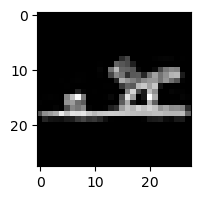

1/1 [==============================] - 0s 358ms/step
예측값:  Sandal


In [45]:
# 베스트 모델 로딩
model = load_model(FILENAME)

# 임의 데이터를 예측하고 정답과 비교하기
idx_rand = np.random.randint(0, X_test.shape[0])
print('목표값: ')
plt.figure(figsize=(2,2))
plt.imshow(X_test[idx_rand], cmap='gray')
plt.show()
Y_label_list = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']
print('예측값: ', Y_label_list[np.argmax(model.predict(X_test[idx_rand][np.newaxis,:]))])

# **Problem:** 컬러사물이미지 분류

## Data Preprocessing

In [46]:
# Train, Test 로딩
mnist = keras.datasets.cifar10
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

170498071/170498071 [==============================] - 29s 0us/step


In [47]:
# 데이터의 갯수와 크기 확인
print('---------train----------')
print('X: ', X_train.shape, X_train.min(), X_train.max())
print('Y: ', Y_train.shape)
print('---------test---------')
print('X: ', X_test.shape, X_test.min(), X_test.max())
print('Y: ', Y_test.shape)

---------train----------
X:  (50000, 32, 32, 3) 0 255
Y:  (50000, 1)
---------test---------
X:  (10000, 32, 32, 3) 0 255
Y:  (10000, 1)


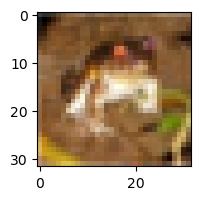

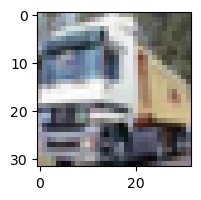

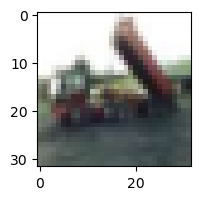

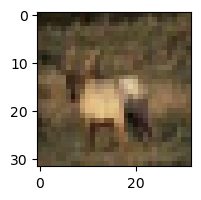

Label of train:  ['Frog', 'Truck', 'Truck', 'Deer']


In [48]:
# 샘플 데이터 시각화
# 0에서 255 사이의 값을 가진 데이터 시각화
for i in range(4):
  plt.figure(figsize=(2,2))
  plt.imshow(X_train[i])
  plt.show()

Y_label_list = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
                'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
print('Label of train: ', [Y_label_list[num] for num in Y_train.flatten()[:4]])

## MLP

<img src='https://github.com/ahn283/finance/blob/main/deep_learning/img/DL_MLP_Custom.PNG?raw=true' width=500>

normalized X:  (50000, 32, 32, 3) 0.0 1.0
normalized X:  (10000, 32, 32, 3) 0.0 1.0
X_train:  (50000, 3072) Y_train:  (50000, 10)
X_test:  (10000, 3072) Y_test:  (10000, 10)
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 3072)]            0         
                                                                 
 dense_17 (Dense)            (None, 256)               786688    
                                                                 
 dense_18 (Dense)            (None, 128)               32896     
                                                                 
 dense_19 (Dense)            (None, 10)                1290      
                                                                 
Total params: 820,874
Trainable params: 820,874
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
625/625 [==============================] - 2s 3ms/step - loss: 2.3043 - accuracy: 0.1010 - val_loss: 2.3049 - val_accuracy: 0.0997
Epoch 2/30
625/625 [==============================] - 2s 3ms/step - loss: 2.3049 - accuracy: 0.1002 - val_loss: 2.3031 - val_accuracy: 0.1022
Epoch 3/30
625/625 [==============================] - 2s 3ms/step - loss: 2.3047 - accuracy: 0.0995 - val_loss: 2.3040 - val_accuracy: 0.0980
Epoch 4/30
625/625 [==============================] - 2s 3ms/step - loss: 2.3048 - accuracy: 0.0983 - val_loss: 2.3029 - val_accuracy: 0.0997
Epoch 5/30
625/625 [==============================] - 2s 3ms/step - loss: 2.3044 - accuracy: 0.1013 - val_loss: 2.3027 - val_accuracy: 0.1025
Epoch 6/30
625/625 [==============================] - 2s 3ms/step - loss: 2.3045 - accuracy: 0.0980 - val_loss: 2.3044 - val_accuracy: 0.0997
Epoch 7/30
625/625 [==============================] - 2s 3ms/step - loss: 2.3045 - accuracy: 0.1024 - val_loss: 2.3068 - val_accuracy: 0.0977
Epoch 

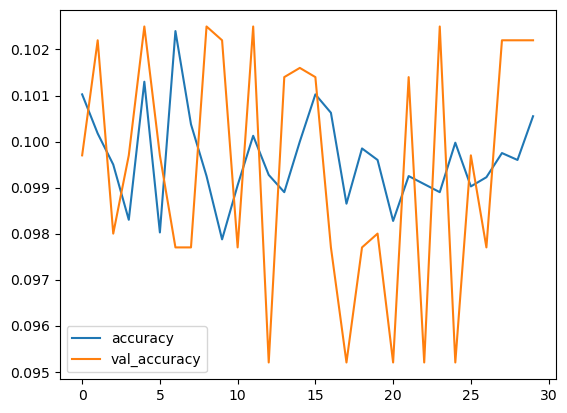

313/313 [==============================] - 0s 756us/step - loss: 2.3039 - accuracy: 0.1000

Test Confusion Maxtrix: 
313/313 [==============================] - 0s 667us/step


Pred,9
True,
0,1000
1,1000
2,1000
3,1000
4,1000
5,1000
6,1000
7,1000
8,1000


In [49]:
# Hyperparameters
tf.random.set_seed(1)
KERNEL_SIZE = (3, 3)
STRIDE = 1
POOL_SIZE = (2, 2)
POOL_STRIDE = 2
PADDING = 'same'
HIDDEN_ACTIVATION = 'relu'    # vashing gradient 해결
HIDDEN_ACTIVATION = 'softmax' # multilabel classification
DROPOUT_RATE = 0.25
LOSS = 'categorical_crossentropy' # multilabel classification
LEARNING_RATE = 0.01
OPTIMIZER = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
METRICS = ['accuracy']
BATCH_SIZE = 64
EPOCHS = 30
VERBOSE = 1
##########
EARLTSTOP_PATIENT = 10
MONITOR = 'val_loss'
FILENAME = os.path.join(os.getcwd(), 'Model', 'ColorObject_MNIST_MLP_h5')
CALLBACK = [callbacks.EarlyStopping(monitor=MONITOR, mode='min',
                                    patience=EARLYSTOP_PATIENT, verbose=1),
            tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
            callbacks.ModelCheckpoint(monitor=MONITOR, mode='min', save_best_only=True,
                                      filepath=FILENAME)]
##########

# train, test 로딩
mnist = keras.datasets.cifar10
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# 데이터 스케일링
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255
print('normalized X: ', X_train.shape, X_train.min(), X_train.max())
print('normalized X: ', X_test.shape, X_test.min(), X_test.max())

# Reshape
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
Y_train = np_utils.to_categorical(Y_train)
Y_test = np_utils.to_categorical(Y_test)
print('X_train: ', X_train.shape, 'Y_train: ', Y_train.shape)
print('X_test: ', X_test.shape, 'Y_test: ', Y_test.shape)

# Build network
inputs = Input(shape=(X_train.shape[1], ))
hiddens = Dense(256, activation=HIDDEN_ACTIVATION)(inputs)
hiddens = Dense(128, activation=HIDDEN_ACTIVATION)(hiddens)
output = Dense(10, activation=OUTPUT_ACTIVATION)(hiddens)

# 네트워크 구축
inputs = Input(shape=(X_train.shape[1],))   
hiddens = Dense(256, activation=HIDDEN_ACTIVATION)(inputs)
hiddens = Dense(128, activation=HIDDEN_ACTIVATION)(hiddens)
output = Dense(10, activation=OUTPUT_ACTIVATION)(hiddens)  
model = Model(inputs, output)  
model.summary() 
plot_model(model) 

# 데이터 학습하기
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
model_fit = model.fit(X_train, Y_train, validation_split=0.2,
                      batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=VERBOSE)
plt.plot(pd.DataFrame(model_fit.history[METRICS[0]]))
plt.plot(pd.DataFrame(model_fit.history['val_'+METRICS[0]]))
plt.legend([METRICS[0], 'val_'+METRICS[0]])
plt.show()

# Train 예측 성능 평가하기
model.evaluate(X_train, Y_train)

# Test 예측 성능 평가하기
model.evaluate(X_test, Y_test)
print('\nTest Confusion Maxtrix: ')
pd.crosstab(np.argmax(Y_test, axis=1), np.argmax(model.predict(X_test), axis=1),
            rownames=['True'], colnames=['Pred'])


## CNN

<img src='https://github.com/ahn283/finance/blob/main/machine_learning/img/CNN_Example.png?raw=true' width=900>

normalized X:  (50000, 32, 32, 3) 0.0 1.0
normalized X:  (10000, 32, 32, 3) 0.0 1.0
X_train: (50000, 32, 32, 3) Y_train: (50000, 10)
X_test: (10000, 32, 32, 3) Y_test: (10000, 10)
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 128)       3584      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 64)        73792     
           

Training:   0%|           0/30 ETA: ?s,  ?epochs/s

Epoch 1/30
625/625 [==============================] - ETA: 0s - loss: 2.3156 - accuracy: 0.1010

Training:   3%|▎          1/30 ETA: 16:02s,  33.19s/epochs

625/625 [==============================] - 33s 53ms/step - loss: 2.3156 - accuracy: 0.1010 - val_loss: 2.3040 - val_accuracy: 0.1014
Epoch 2/30
625/625 [==============================] - ETA: 0s - loss: 2.3038 - accuracy: 0.1011

Training:   7%|▋          2/30 ETA: 15:06s,  32.39s/epochs

625/625 [==============================] - 32s 51ms/step - loss: 2.3038 - accuracy: 0.1011 - val_loss: 2.3026 - val_accuracy: 0.1022
Epoch 3/30
624/625 [============================>.] - ETA: 0s - loss: 2.3037 - accuracy: 0.0990

Training:  10%|█          3/30 ETA: 14:29s,  32.22s/epochs

625/625 [==============================] - 32s 51ms/step - loss: 2.3037 - accuracy: 0.0989 - val_loss: 2.3030 - val_accuracy: 0.0980
Epoch 4/30
625/625 [==============================] - ETA: 0s - loss: 2.3037 - accuracy: 0.0974

Training:  13%|█▎         4/30 ETA: 13:59s,  32.28s/epochs

625/625 [==============================] - 32s 52ms/step - loss: 2.3037 - accuracy: 0.0974 - val_loss: 2.3028 - val_accuracy: 0.1016
Epoch 5/30
625/625 [==============================] - ETA: 0s - loss: 2.3036 - accuracy: 0.0997

Training:  17%|█▋         5/30 ETA: 13:26s,  32.26s/epochs

625/625 [==============================] - 32s 52ms/step - loss: 2.3036 - accuracy: 0.0997 - val_loss: 2.3030 - val_accuracy: 0.1003
Epoch 6/30
625/625 [==============================] - ETA: 0s - loss: 2.3036 - accuracy: 0.1006

Training:  20%|██         6/30 ETA: 12:54s,  32.28s/epochs

625/625 [==============================] - 32s 52ms/step - loss: 2.3036 - accuracy: 0.1006 - val_loss: 2.3038 - val_accuracy: 0.0952
Epoch 7/30
624/625 [============================>.] - ETA: 0s - loss: 2.3036 - accuracy: 0.0999

Training:  23%|██▎        7/30 ETA: 12:27s,  32.52s/epochs

625/625 [==============================] - 33s 53ms/step - loss: 2.3036 - accuracy: 0.0999 - val_loss: 2.3050 - val_accuracy: 0.0977
Epoch 8/30
625/625 [==============================] - ETA: 0s - loss: 2.3037 - accuracy: 0.1008

Training:  27%|██▋        8/30 ETA: 11:56s,  32.56s/epochs

625/625 [==============================] - 33s 52ms/step - loss: 2.3037 - accuracy: 0.1008 - val_loss: 2.3031 - val_accuracy: 0.0977
Epoch 9/30
624/625 [============================>.] - ETA: 0s - loss: 2.3035 - accuracy: 0.0999

Training:  30%|███        9/30 ETA: 11:25s,  32.65s/epochs

625/625 [==============================] - 33s 53ms/step - loss: 2.3035 - accuracy: 0.1000 - val_loss: 2.3031 - val_accuracy: 0.1025
Epoch 10/30
625/625 [==============================] - ETA: 0s - loss: 2.3200 - accuracy: 0.0991

Training:  33%|███▎       10/30 ETA: 10:54s,  32.70s/epochs

625/625 [==============================] - 33s 52ms/step - loss: 2.3200 - accuracy: 0.0991 - val_loss: 2.3033 - val_accuracy: 0.1016
Epoch 11/30
625/625 [==============================] - ETA: 0s - loss: 2.3036 - accuracy: 0.0984

Training:  37%|███▋       11/30 ETA: 10:33s,  33.36s/epochs

625/625 [==============================] - 35s 56ms/step - loss: 2.3036 - accuracy: 0.0984 - val_loss: 2.3033 - val_accuracy: 0.0977
Epoch 12/30
624/625 [============================>.] - ETA: 0s - loss: 2.3036 - accuracy: 0.0992

Training:  40%|████       12/30 ETA: 09:50s,  32.78s/epochs

625/625 [==============================] - 31s 50ms/step - loss: 2.3036 - accuracy: 0.0992 - val_loss: 2.3029 - val_accuracy: 0.1025
Epoch 12: early stopping


Training:  40%|████       12/30 ETA: 09:47s,  32.63s/epochs


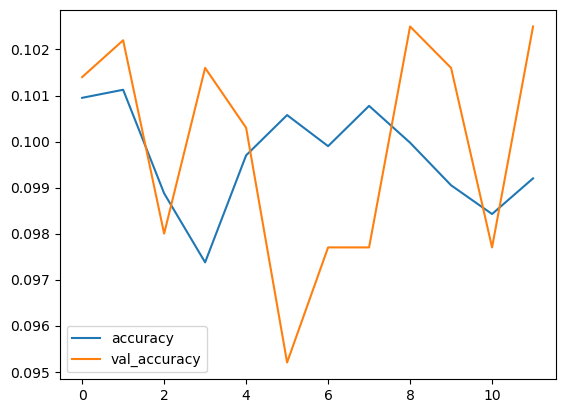

313/313 [==============================] - 3s 8ms/step - loss: 2.3029 - accuracy: 0.1000

Test Confusion Maxtrix: 
313/313 [==============================] - 3s 8ms/step


Pred,5
True,
0,1000
1,1000
2,1000
3,1000
4,1000
5,1000
6,1000
7,1000
8,1000


In [50]:
# 하이퍼파라미터
tf.random.set_seed(1)
KERNEL_SIZE = (3,3)
STRIDE = 1
POOL_SIZE = (2,2)
POOL_STRIDE = 2
PADDING = 'same'
HIDDEN_ACTIVATION = 'relu'
OUTPUT_ACTIVATION = 'softmax'
DROPOUT_RATIO = 0.25
LOSS = 'categorical_crossentropy'
LEARNING_RATE = 0.01
OPTIMIZER = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
METRICS = ['accuracy']
BATCH_SIZE = 64
EPOCHS = 30
VERBOSE = 1
################
EARLYSTOP_PATIENT = 10
MONITOR = 'val_loss'
FILENAME = os.path.join(os.getcwd(),'Model','ColorObject_MNIST_CNN.h5')
CALLBACK = [callbacks.EarlyStopping(monitor=MONITOR, mode='min', 
                                    patience=EARLYSTOP_PATIENT, verbose=1),
            tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
            callbacks.ModelCheckpoint(monitor=MONITOR, mode='min', save_best_only=True, 
                                      filepath=FILENAME)]
################

# Train, Test로 로딩
mnist = keras.datasets.cifar10
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# 데이터 스케일링
X_train = X_train.astype("float32")/255
X_test = X_test.astype("float32")/255
print('normalized X: ', X_train.shape, X_train.min(), X_train.max())
print('normalized X: ', X_test.shape, X_test.min(), X_test.max())

# Reshape
Y_train = np_utils.to_categorical(Y_train)
Y_test = np_utils.to_categorical(Y_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# 네트워크 구축
inputs = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))   
hiddens = Conv2D(128, kernel_size=KERNEL_SIZE, strides=STRIDE, padding=PADDING, 
                 activation=HIDDEN_ACTIVATION)(inputs)
hiddens = MaxPooling2D(pool_size=POOL_SIZE, strides=POOL_STRIDE)(hiddens)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
hiddens = Conv2D(64, kernel_size=KERNEL_SIZE, strides=STRIDE, padding=PADDING, 
                 activation=HIDDEN_ACTIVATION)(hiddens)
hiddens = MaxPooling2D(pool_size=POOL_SIZE, strides=POOL_STRIDE)(hiddens)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
hiddens = Flatten()(hiddens)
hiddens = Dense(32, activation=HIDDEN_ACTIVATION)(hiddens)  
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
output = Dense(10, activation=OUTPUT_ACTIVATION)(hiddens)  
model = Model(inputs, output)  
model.summary() 
plot_model(model) 

# 데이터 학습하기
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
model_fit = model.fit(X_train, Y_train, validation_split=0.2,
                      batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=VERBOSE,
                      callbacks=CALLBACK)
plt.plot(pd.DataFrame(model_fit.history[METRICS[0]]))
plt.plot(pd.DataFrame(model_fit.history['val_'+METRICS[0]]))
plt.legend([METRICS[0], 'val_'+METRICS[0]])
plt.show()

# Train 예측 성능 평가하기
model.evaluate(X_train, Y_train)

# Test 예측 성능 평가하기
model.evaluate(X_test, Y_test)
print('\nTest Confusion Maxtrix: ')
pd.crosstab(np.argmax(Y_test, axis=1), np.argmax(model.predict(X_test), axis=1),
            rownames=['True'], colnames=['Pred'])

목표값: 


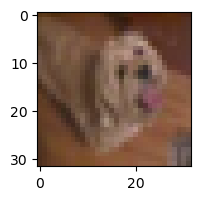

1/1 [==============================] - 0s 29ms/step
예측값:  Truck


In [51]:
# 베스트 모델 로딩
model = load_model(FILENAME)

# 임의 데이터를 예측하고 정답과 비교하기
idx_rand = np.random.randint(0, X_test.shape[0])
print('목표값: ')
plt.figure(figsize=(2,2))
plt.imshow(X_test[idx_rand], cmap='gray')
plt.show()
Y_label_list = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
                'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
print('예측값: ', Y_label_list[np.argmax(model.predict(X_test[idx_rand][np.newaxis,:]))])

## ResNet50

<img src='https://github.com/ahn283/finance/blob/main/machine_learning/img/CNN_ResNet.png?raw=true' width=1000>

normalized X:  (50000, 32, 32, 3) 0.0 1.0
normalized X:  (10000, 32, 32, 3) 0.0 1.0
X_train: (50000, 32, 32, 3) Y_train: (50000, 10)
X_test: (10000, 32, 32, 3) Y_test: (10000, 10)
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_11[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn 

Training:   0%|           0/30 ETA: ?s,  ?epochs/s

Epoch 1/30
625/625 [==============================] - ETA: 0s - loss: 3.0518 - accuracy: 0.1750

Training:   3%|▎          1/30 ETA: 3:00:34s,  373.62s/epochs

625/625 [==============================] - 374s 595ms/step - loss: 3.0518 - accuracy: 0.1750 - val_loss: 2.0947 - val_accuracy: 0.2054
Epoch 2/30
625/625 [==============================] - ETA: 0s - loss: 1.9162 - accuracy: 0.2874

Training:   7%|▋          2/30 ETA: 2:52:20s,  369.30s/epochs

625/625 [==============================] - 366s 585ms/step - loss: 1.9162 - accuracy: 0.2874 - val_loss: 3.1880 - val_accuracy: 0.2348
Epoch 3/30
625/625 [==============================] - ETA: 0s - loss: 1.6062 - accuracy: 0.4013

Training:  10%|█          3/30 ETA: 2:45:31s,  367.83s/epochs

625/625 [==============================] - 366s 586ms/step - loss: 1.6062 - accuracy: 0.4013 - val_loss: 1.6217 - val_accuracy: 0.4005
Epoch 4/30
625/625 [==============================] - ETA: 0s - loss: 1.4558 - accuracy: 0.4631

Training:  13%|█▎         4/30 ETA: 2:39:02s,  367.03s/epochs

625/625 [==============================] - 365s 585ms/step - loss: 1.4558 - accuracy: 0.4631 - val_loss: 7.6928 - val_accuracy: 0.2357
Epoch 5/30
625/625 [==============================] - ETA: 0s - loss: 1.3312 - accuracy: 0.5165

Training:  17%|█▋         5/30 ETA: 2:32:44s,  366.58s/epochs

625/625 [==============================] - 366s 586ms/step - loss: 1.3312 - accuracy: 0.5165 - val_loss: 1.3073 - val_accuracy: 0.5385
Epoch 6/30
625/625 [==============================] - ETA: 0s - loss: 1.1458 - accuracy: 0.5898

Training:  20%|██         6/30 ETA: 2:26:40s,  366.69s/epochs

625/625 [==============================] - 367s 587ms/step - loss: 1.1458 - accuracy: 0.5898 - val_loss: 1.5566 - val_accuracy: 0.5032
Epoch 7/30
625/625 [==============================] - ETA: 0s - loss: 1.0168 - accuracy: 0.6423

Training:  23%|██▎        7/30 ETA: 2:20:30s,  366.56s/epochs

625/625 [==============================] - 367s 587ms/step - loss: 1.0168 - accuracy: 0.6423 - val_loss: 1.3031 - val_accuracy: 0.5695
Epoch 8/30
625/625 [==============================] - ETA: 0s - loss: 0.9159 - accuracy: 0.6773

Training:  27%|██▋        8/30 ETA: 2:14:37s,  367.17s/epochs

625/625 [==============================] - 368s 589ms/step - loss: 0.9159 - accuracy: 0.6773 - val_loss: 1.3895 - val_accuracy: 0.5836
Epoch 9/30
625/625 [==============================] - ETA: 0s - loss: 0.8693 - accuracy: 0.6970

Training:  30%|███        9/30 ETA: 2:08:48s,  368.04s/epochs

625/625 [==============================] - 370s 592ms/step - loss: 0.8693 - accuracy: 0.6970 - val_loss: 1.5961 - val_accuracy: 0.5283
Epoch 10/30
625/625 [==============================] - ETA: 0s - loss: 0.7985 - accuracy: 0.7236

Training:  33%|███▎       10/30 ETA: 2:02:41s,  368.08s/epochs

625/625 [==============================] - 369s 590ms/step - loss: 0.7985 - accuracy: 0.7236 - val_loss: 1.1536 - val_accuracy: 0.6400
Epoch 11/30
625/625 [==============================] - ETA: 0s - loss: 0.7520 - accuracy: 0.7411

Training:  37%|███▋       11/30 ETA: 1:56:45s,  368.73s/epochs

625/625 [==============================] - 370s 592ms/step - loss: 0.7520 - accuracy: 0.7411 - val_loss: 1.5438 - val_accuracy: 0.5000
Epoch 12/30
625/625 [==============================] - ETA: 0s - loss: 0.7247 - accuracy: 0.7506

Training:  40%|████       12/30 ETA: 1:50:47s,  369.31s/epochs

625/625 [==============================] - 371s 593ms/step - loss: 0.7247 - accuracy: 0.7506 - val_loss: 1.7225 - val_accuracy: 0.5314
Epoch 13/30
625/625 [==============================] - ETA: 0s - loss: 0.6757 - accuracy: 0.7676

Training:  43%|████▎      13/30 ETA: 1:44:46s,  369.81s/epochs

625/625 [==============================] - 371s 594ms/step - loss: 0.6757 - accuracy: 0.7676 - val_loss: 1.6243 - val_accuracy: 0.6294
Epoch 14/30
625/625 [==============================] - ETA: 0s - loss: 1.0301 - accuracy: 0.6554

Training:  47%|████▋      14/30 ETA: 1:38:48s,  370.53s/epochs

625/625 [==============================] - 373s 596ms/step - loss: 1.0301 - accuracy: 0.6554 - val_loss: 0.9425 - val_accuracy: 0.6793
Epoch 15/30
625/625 [==============================] - ETA: 0s - loss: 0.6640 - accuracy: 0.7730

Training:  50%|█████      15/30 ETA: 1:32:45s,  371.03s/epochs

625/625 [==============================] - 372s 595ms/step - loss: 0.6640 - accuracy: 0.7730 - val_loss: 0.9394 - val_accuracy: 0.6874
Epoch 16/30
625/625 [==============================] - ETA: 0s - loss: 0.5567 - accuracy: 0.8088

Training:  53%|█████▎     16/30 ETA: 1:26:39s,  371.42s/epochs

625/625 [==============================] - 372s 595ms/step - loss: 0.5567 - accuracy: 0.8088 - val_loss: 1.2662 - val_accuracy: 0.6019
Epoch 17/30
625/625 [==============================] - ETA: 0s - loss: 0.5074 - accuracy: 0.8251

Training:  57%|█████▋     17/30 ETA: 1:21:41s,  377.01s/epochs

625/625 [==============================] - 390s 624ms/step - loss: 0.5074 - accuracy: 0.8251 - val_loss: 1.1208 - val_accuracy: 0.6648
Epoch 18/30
625/625 [==============================] - ETA: 0s - loss: 0.4666 - accuracy: 0.8410

Training:  60%|██████     18/30 ETA: 1:16:22s,  381.88s/epochs

625/625 [==============================] - 393s 629ms/step - loss: 0.4666 - accuracy: 0.8410 - val_loss: 1.5038 - val_accuracy: 0.5694
Epoch 19/30
625/625 [==============================] - ETA: 0s - loss: 0.4329 - accuracy: 0.8500

Training:  63%|██████▎    19/30 ETA: 1:10:33s,  384.83s/epochs

625/625 [==============================] - 392s 627ms/step - loss: 0.4329 - accuracy: 0.8500 - val_loss: 0.9212 - val_accuracy: 0.7177
Epoch 20/30
625/625 [==============================] - ETA: 0s - loss: 0.3553 - accuracy: 0.8786

Training:  67%|██████▋    20/30 ETA: 1:04:44s,  388.47s/epochs

625/625 [==============================] - 397s 635ms/step - loss: 0.3553 - accuracy: 0.8786 - val_loss: 1.0285 - val_accuracy: 0.7130
Epoch 21/30
625/625 [==============================] - ETA: 0s - loss: 0.3398 - accuracy: 0.8854

Training:  70%|███████    21/30 ETA: 58:22s,  389.17s/epochs  

625/625 [==============================] - 391s 625ms/step - loss: 0.3398 - accuracy: 0.8854 - val_loss: 2.2231 - val_accuracy: 0.6281
Epoch 22/30
625/625 [==============================] - ETA: 0s - loss: 0.2947 - accuracy: 0.8992

Training:  73%|███████▎   22/30 ETA: 52:16s,  392.07s/epochs

625/625 [==============================] - 399s 638ms/step - loss: 0.2947 - accuracy: 0.8992 - val_loss: 0.9466 - val_accuracy: 0.7213
Epoch 23/30
625/625 [==============================] - ETA: 0s - loss: 0.2610 - accuracy: 0.9122

Training:  77%|███████▋   23/30 ETA: 45:51s,  393.08s/epochs

625/625 [==============================] - 395s 633ms/step - loss: 0.2610 - accuracy: 0.9122 - val_loss: 0.9852 - val_accuracy: 0.7347
Epoch 24/30
625/625 [==============================] - ETA: 0s - loss: 0.2066 - accuracy: 0.9308

Training:  80%|████████   24/30 ETA: 39:15s,  392.56s/epochs

625/625 [==============================] - 391s 626ms/step - loss: 0.2066 - accuracy: 0.9308 - val_loss: 1.0609 - val_accuracy: 0.7227
Epoch 25/30
625/625 [==============================] - ETA: 0s - loss: 0.2107 - accuracy: 0.9290

Training:  83%|████████▎  25/30 ETA: 32:40s,  392.10s/epochs

625/625 [==============================] - 391s 625ms/step - loss: 0.2107 - accuracy: 0.9290 - val_loss: 7.0117 - val_accuracy: 0.1684
Epoch 26/30
625/625 [==============================] - ETA: 0s - loss: 0.2888 - accuracy: 0.9022

Training:  87%|████████▋  26/30 ETA: 25:58s,  389.63s/epochs

625/625 [==============================] - 384s 614ms/step - loss: 0.2888 - accuracy: 0.9022 - val_loss: 1.7540 - val_accuracy: 0.6316
Epoch 27/30
625/625 [==============================] - ETA: 0s - loss: 0.3164 - accuracy: 0.8976

Training:  90%|█████████  27/30 ETA: 19:16s,  385.51s/epochs

625/625 [==============================] - 376s 601ms/step - loss: 0.3164 - accuracy: 0.8976 - val_loss: 1.0028 - val_accuracy: 0.7367
Epoch 28/30
625/625 [==============================] - ETA: 0s - loss: 0.1693 - accuracy: 0.9436

Training:  93%|█████████▎ 28/30 ETA: 12:43s,  381.52s/epochs

625/625 [==============================] - 372s 596ms/step - loss: 0.1693 - accuracy: 0.9436 - val_loss: 1.2970 - val_accuracy: 0.7163
Epoch 29/30
625/625 [==============================] - ETA: 0s - loss: 0.1211 - accuracy: 0.9588

Training:  97%|█████████▋ 29/30 ETA: 06:19s,  379.34s/epochs

625/625 [==============================] - 374s 599ms/step - loss: 0.1211 - accuracy: 0.9588 - val_loss: 1.3800 - val_accuracy: 0.7085
Epoch 29: early stopping


Training:  97%|█████████▋ 29/30 ETA: 06:17s,  377.64s/epochs


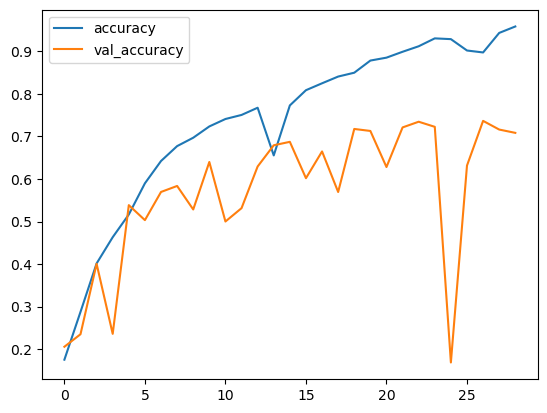

313/313 [==============================] - 12s 39ms/step - loss: 1.4138 - accuracy: 0.7007

Test Confusion Maxtrix: 
313/313 [==============================] - 12s 39ms/step


Pred,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,812,34,22,64,2,8,7,1,23,27
1,14,920,2,9,1,9,2,0,0,43
2,75,18,564,155,23,79,57,6,6,17
3,27,13,41,705,9,137,47,8,2,11
4,37,2,62,211,476,93,60,38,11,10
5,8,4,18,304,10,620,19,13,0,4
6,5,18,26,106,11,42,773,1,2,16
7,48,11,25,95,22,103,8,655,5,28
8,104,98,15,29,2,14,7,1,712,18


In [52]:
# 하이퍼파라미터
tf.random.set_seed(1)
KERNEL_SIZE = (3,3)
STRIDE = 1
POOL_SIZE = (2,2)
POOL_STRIDE = 2
PADDING = 'same'
HIDDEN_ACTIVATION = 'relu'
OUTPUT_ACTIVATION = 'softmax'
DROPOUT_RATIO = 0.25
LOSS = 'categorical_crossentropy'
LEARNING_RATE = 0.01
OPTIMIZER = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
METRICS = ['accuracy']
BATCH_SIZE = 64
EPOCHS = 30
VERBOSE = 1
################
EARLYSTOP_PATIENT = 10
MONITOR = 'val_loss'
FILENAME = os.path.join(os.getcwd(),'Model','ColorObject_MNIST_ResNet50.h5')
CALLBACK = [callbacks.EarlyStopping(monitor=MONITOR, mode='min', 
                                    patience=EARLYSTOP_PATIENT, verbose=1),
            tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
            callbacks.ModelCheckpoint(monitor=MONITOR, mode='min', save_best_only=True, 
                                      filepath=FILENAME)]
################

# Train, Test로 로딩
mnist = keras.datasets.cifar10
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# 데이터 스케일링
X_train = X_train.astype("float32")/255
X_test = X_test.astype("float32")/255
print('normalized X: ', X_train.shape, X_train.min(), X_train.max())
print('normalized X: ', X_test.shape, X_test.min(), X_test.max())

# Reshape
Y_train = np_utils.to_categorical(Y_train)
Y_test = np_utils.to_categorical(Y_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)


# Build network
inputs = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
model = ResNet50(input_tensor=inputs, pooling='max', include_top=True,
                 weights=None, classes=Y_train.shape[1])
model.summary()
plot_model(model)

# 데이터 학습하기
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
model_fit = model.fit(X_train, Y_train, validation_split=0.2,
                      batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=VERBOSE,
                      callbacks=CALLBACK)
plt.plot(pd.DataFrame(model_fit.history[METRICS[0]]))
plt.plot(pd.DataFrame(model_fit.history['val_'+METRICS[0]]))
plt.legend([METRICS[0], 'val_'+METRICS[0]])
plt.show()

# Train 예측 성능 평가하기
model.evaluate(X_train, Y_train)

# Test 예측 성능 평가하기
model.evaluate(X_test, Y_test)
print('\nTest Confusion Maxtrix: ')
pd.crosstab(np.argmax(Y_test, axis=1), np.argmax(model.predict(X_test), axis=1),
            rownames=['True'], colnames=['Pred'])

목표값: 


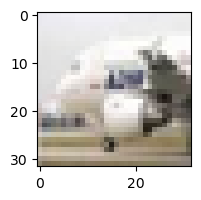

1/1 [==============================] - 0s 353ms/step
예측값:  Horse


In [53]:
# 베스트 모델 로딩
model = load_model(FILENAME)

# 임의 데이터를 예측하고 정답과 비교하기
idx_rand = np.random.randint(0, X_test.shape[0])
print('목표값: ')
plt.figure(figsize=(2,2))
plt.imshow(X_test[idx_rand], cmap='gray')
plt.show()
Y_label_list = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
                'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
print('예측값: ', Y_label_list[np.argmax(model.predict(X_test[idx_rand][np.newaxis,:]))])

# **Problem:** 보스턴 집값 예측

|   **변수**  |              **설명**              |
|-----|-----|
|  **Price**  |            주택 가격           |
|   **CRIM**  |        1인당 범죄 발생률       |
|    **ZN**   |       주택용 토지의 비율       |
|  **INDUS**  |      비소매 상업지역 비율      |
|   **CHAS**  |    찰스강 인접 여부(인접=1)    |
|   **NOX**   |         일산화질소 농도        |
|    **RM**   |            방의 개수           |
|   **AGE**   | 1940년 이전에 건축된 주택 비율 |
|   **DIS**   |     주요 5대 회사와의 거리     |
|   **RAD**   |         고속도로 접근성        |
|   **TAX**   |             재산세             |
| **PTRATIO** |       교사와 학생의 비율       |
|    **B**    |         흑인 거주 비율         |
|  **LSTAT**  |          저소득층 비율         |

## MLP

<img src='https://github.com/ahn283/finance/blob/main/deep_learning/img/DL_MLP_Custom.PNG?raw=true'
 width=500>

(404, 13) (404, 1)
(102, 13) (102, 1)
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 18)]              0         
                                                                 
 dense_22 (Dense)            (None, 256)               4864      
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_23 (Dense)            (None, 128)               32896     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_24 (Dense)            (None, 64)                8256      
                                                                 
 dropout_11 (Dropout)

Training:   7%|▋          36/500 ETA: 00:11s,  39.31epochs/s

Epoch 36: early stopping


Training:   7%|▋          36/500 ETA: 00:16s,  28.51epochs/s


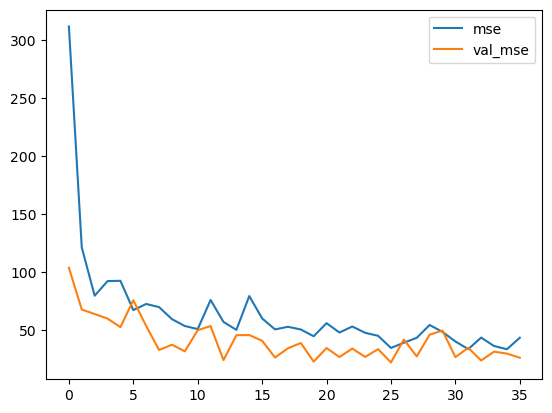

4/4 [==============================] - 0s 548us/step


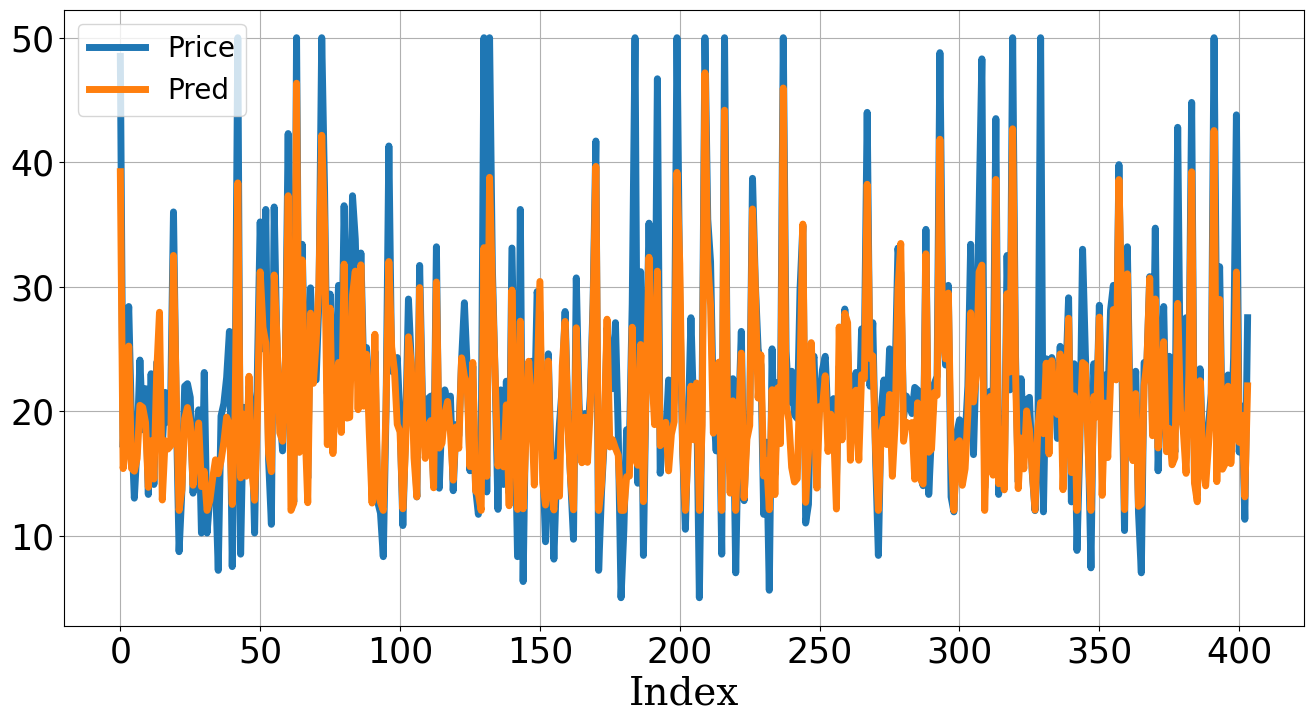

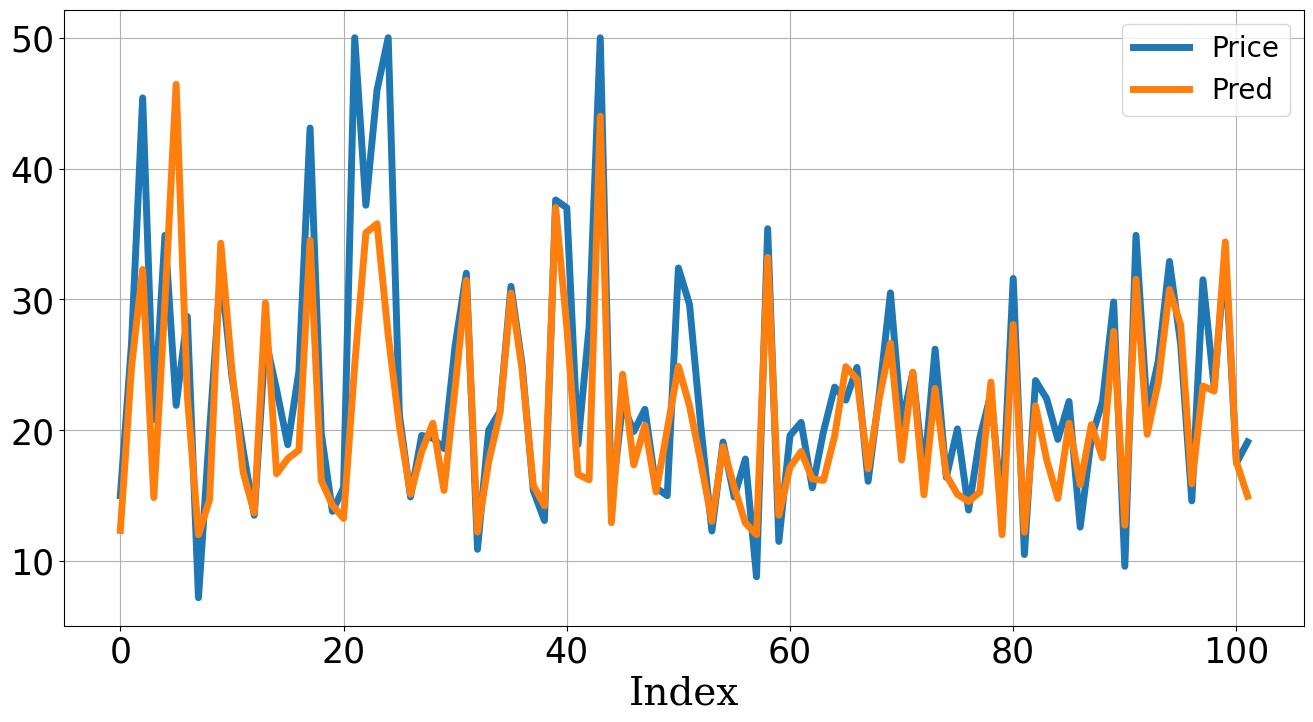

,MAE,MSE,MAPE
Train,2.95,19.84,0.14
Test,3.48,31.58,0.15


In [57]:
# 하이퍼파라미터
tf.random.set_seed(1)
KERNEL_SIZE = (3,3)
STRIDE = 1
POOL_SIZE = (2,2)
POOL_STRIDE = 2
PADDING = 'same'
HIDDEN_ACTIVATION = 'relu'
OUTPUT_ACTIVATION = 'linear'
REGULARIZER = regularizers.l2(0.01)
DROPOUT_RATIO = 0.25
LOSS = 'mse'
LEARNING_RATE = 0.01
OPTIMIZER = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
METRICS = ['mse']
BATCH_SIZE = 32
EPOCHS = 500
VERBOSE = 0
################
EARLYSTOP_PATIENT = 10
MONITOR = 'val_loss'
FILENAME = os.path.join(os.getcwd(),'Model','BostonHousing_MLP.h5')
CALLBACK = [callbacks.EarlyStopping(monitor=MONITOR, mode='min', 
                                    patience=EARLYSTOP_PATIENT, verbose=1),
            tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
            callbacks.ModelCheckpoint(monitor=MONITOR, mode='min', save_best_only=True, 
                                      filepath=FILENAME)]
################


# 데이터 전처리
from module_regression import *

df = pd.read_csv(os.path.join(os.getcwd(), 'data', 'Price_modify.csv'))
df = prep(df)

Y_colname = ['Price']
X_train, X_test, Y_train, Y_test = datasplit(df, Y_colname)

X_train_fe = feature_engineering(X_train)
X_test_fe = feature_engineering(X_test)
X_train_fe, X_test_fe = col_mapping(X_train_fe, X_test_fe)   

scaler = preprocessing.MinMaxScaler()
X_train_fes, X_test_fes = scale(scaler, X_train_fe, X_test_fe)

# 네트워크 구축
inputs = Input(shape=(X_train_fes.shape[1],))   
hiddens = Dense(256, activation=HIDDEN_ACTIVATION, kernel_regularizer=REGULARIZER)(inputs)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
hiddens = Dense(128, activation=HIDDEN_ACTIVATION, kernel_regularizer=REGULARIZER)(hiddens)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
hiddens = Dense(64, activation=HIDDEN_ACTIVATION, kernel_regularizer=REGULARIZER)(hiddens)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
hiddens = Dense(32, activation=HIDDEN_ACTIVATION, kernel_regularizer=REGULARIZER)(hiddens)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
output = Dense(1, activation=OUTPUT_ACTIVATION)(hiddens)  
model = Model(inputs, output)  
model.summary() 
plot_model(model) 

## 데이터 학습하기
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
model_fit = model.fit(X_train_fes, Y_train, validation_split=0.2,
                      batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=VERBOSE,
                      callbacks=CALLBACK)
plt.plot(pd.DataFrame(model_fit.history[METRICS[0]]))
plt.plot(pd.DataFrame(model_fit.history['val_'+METRICS[0]]))
plt.legend([METRICS[0], 'val_'+METRICS[0]])
plt.show()

## 예측하기
Y_trpred = pd.DataFrame(model.predict(X_train_fes), 
                        index=Y_train.index, columns=['Pred'])
Y_tepred = pd.DataFrame(model.predict(X_test_fes), 
                        index=Y_test.index, columns=['Pred'])
plot_prediction(pd.concat([Y_train, Y_trpred], axis=1).reset_index().iloc[:,1:])
plot_prediction(pd.concat([Y_test, Y_tepred], axis=1).reset_index().iloc[:,1:])

# 분석 검증
Score_nn_early = evaluation_reg_trte(Y_train, Y_trpred, Y_test, Y_tepred)
display(Score_nn_early)

4/4 [==============================] - 0s 760us/step


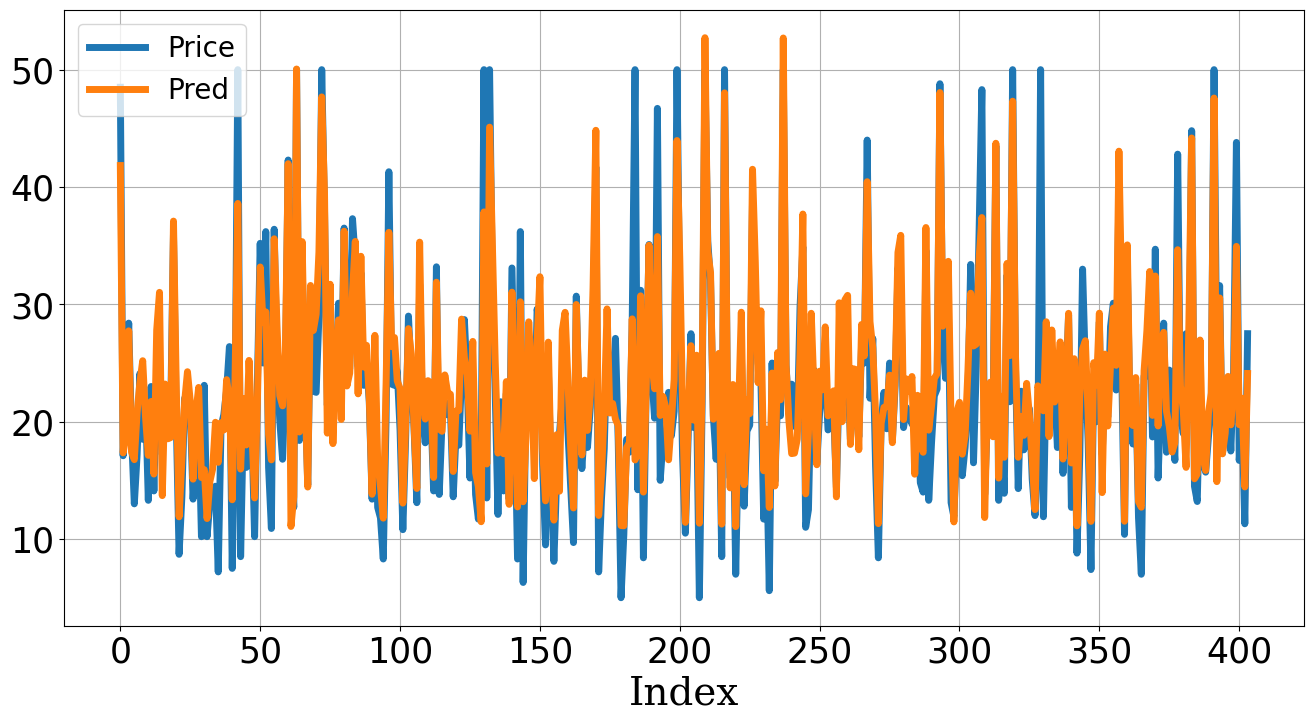

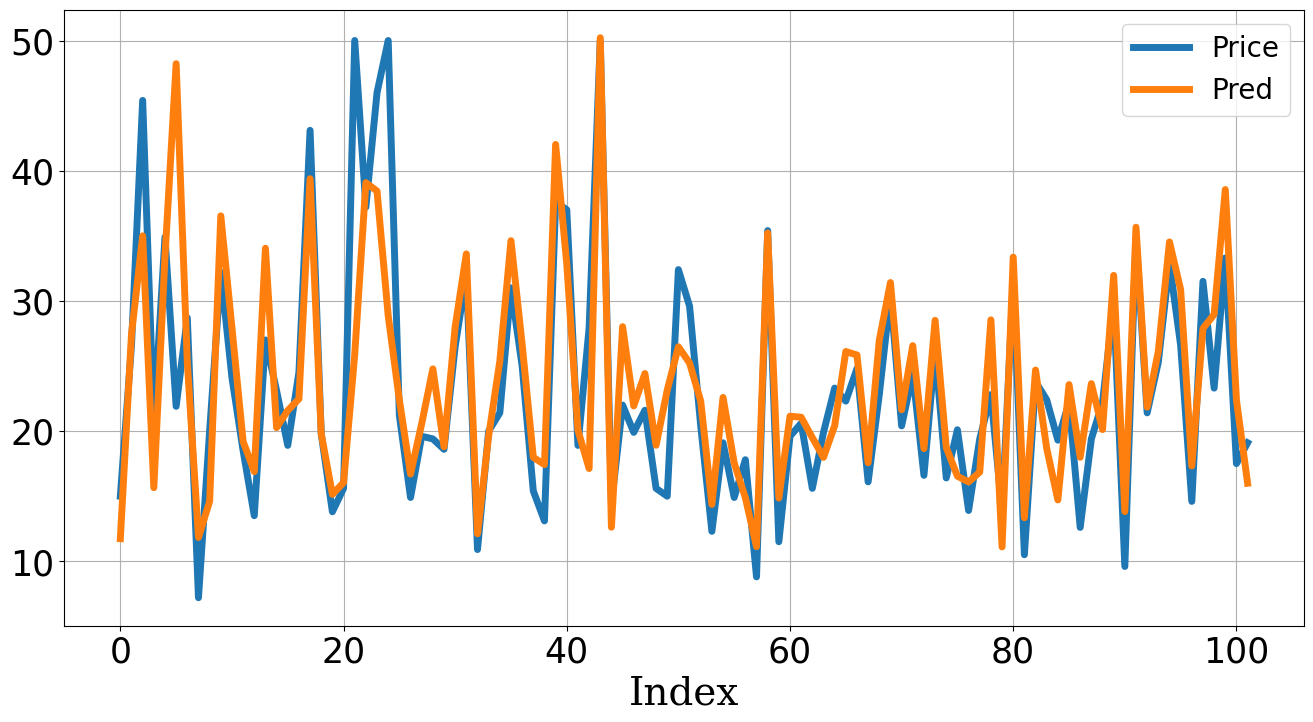

,MAE,MSE,MAPE
Train,2.87,16.70,0.16
Test,3.61,29.61,0.17


In [58]:
# 베스트 모델 로딩
model = load_model(FILENAME)

## 예측하기
Y_trpred = pd.DataFrame(model.predict(X_train_fes), 
                        index=Y_train.index, columns=['Pred'])
Y_tepred = pd.DataFrame(model.predict(X_test_fes), 
                        index=Y_test.index, columns=['Pred'])
plot_prediction(pd.concat([Y_train, Y_trpred], axis=1).reset_index().iloc[:,1:])
plot_prediction(pd.concat([Y_test, Y_tepred], axis=1).reset_index().iloc[:,1:])

# 분석 검증
Score_nn_early = evaluation_reg_trte(Y_train, Y_trpred, Y_test, Y_tepred)
display(Score_nn_early)

## CNN

<img src='https://github.com/ahn283/finance/blob/main/machine_learning/img/CNN_Example.png?raw=true' width=300>

<img src='https://github.com/ahn283/finance/blob/main/machine_learning/img/Conv1D2D3D.png?raw=true' width=800>

(404, 13) (404, 1)
(102, 13) (102, 1)
X_train: (404, 18, 1) Y_train: (404, 1)
X_test: (102, 18, 1) Y_test: (102, 1)
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 18, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 18, 128)           512       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 9, 128)           0         
 )                                                               
                                                                 
 dropout_13 (Dropout)        (None, 9, 128)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 9, 64)             24640     
                                                                 
 max_pool

Training:  14%|█▎         68/500 ETA: 00:14s,  29.75epochs/s

Epoch 69: early stopping


Training:  14%|█▍         69/500 ETA: 00:17s,  25.18epochs/s


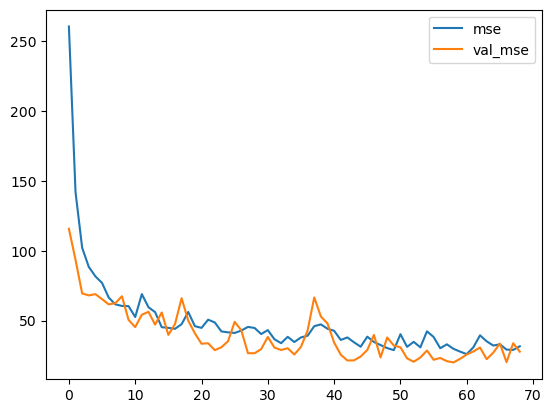

4/4 [==============================] - 0s 5ms/step


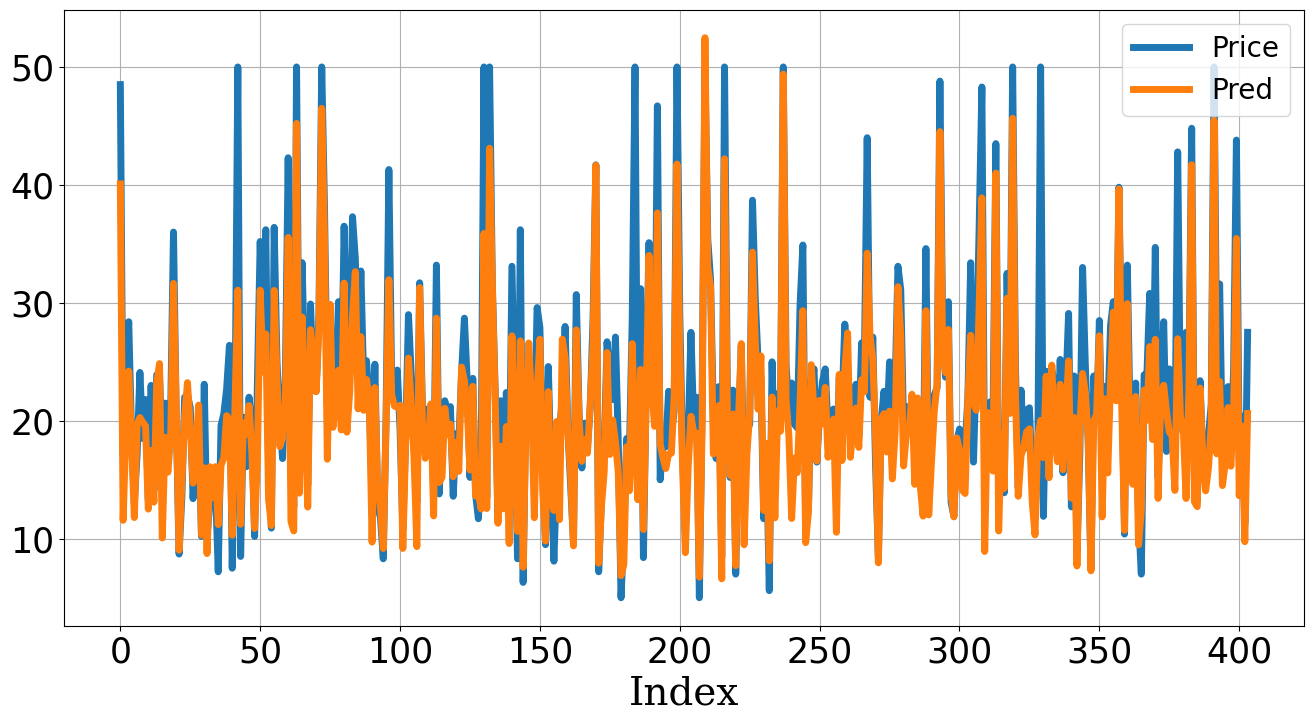

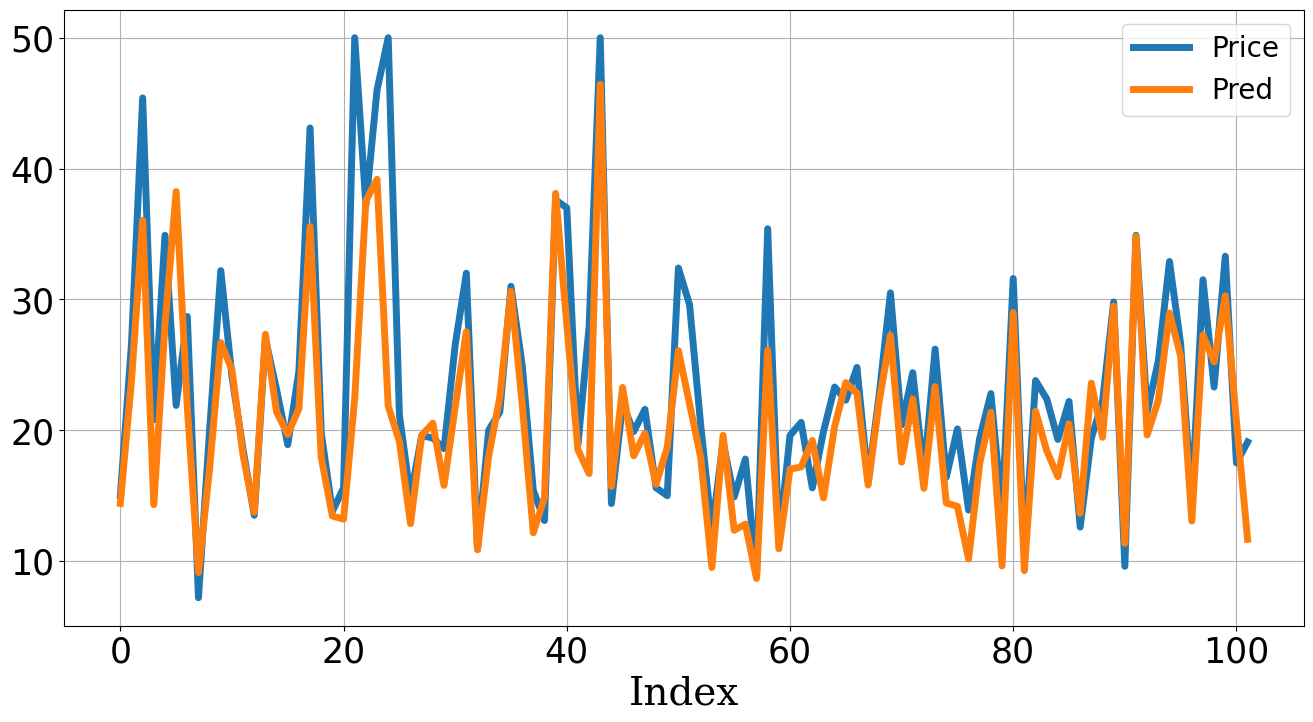

,MAE,MSE,MAPE
Train,2.89,18.66,0.13
Test,3.44,30.92,0.14


In [59]:
# Hyperparameters
tf.random.set_seed(1)
KERNEL_SIZE = 3
STRIDE = 1
POOL_SIZE = 2
POOL_STRIDE = 2
PADDING = 'same'
HIDDEN_ACTIVATION = 'relu'
OUTPUT_ACTIVATION = 'linear'
REGULARIZER = regularizers.l2(0.01)
DROPOUT_RATIO = 0.25
LOSS = 'mse'
LEARNING_RATE = 0.01
OPTIMIZER = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
METRICS = ['mse']
BATCH_SIZE = 32
EPOCHS = 500
VERBOSE = 0
################
EARLYSTOP_PATIENT = 10
MONITOR = 'val_loss'
FILENAME = os.path.join(os.getcwd(),'Model','BostonHousing_CNN.h5')
CALLBACK = [callbacks.EarlyStopping(monitor=MONITOR, mode='min', 
                                    patience=EARLYSTOP_PATIENT, verbose=1),
            tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
            callbacks.ModelCheckpoint(monitor=MONITOR, mode='min', save_best_only=True, 
                                      filepath=FILENAME)]
################

# 데이터 로딩
location = os.path.join(os.getcwd(), 'data', 'Price_Modify.csv')
df = pd.read_csv(location)

# 데이터 전처리
df = prep(df)

Y_colname = ['Price']
X_train, X_test, Y_train, Y_test = datasplit(df, Y_colname)

X_train_fe = feature_engineering(X_train)
X_test_fe = feature_engineering(X_test)
X_train_fe, X_test_fe = col_mapping(X_train_fe, X_test_fe)   

scaler = preprocessing.MinMaxScaler()
X_train_fes, X_test_fes = scale(scaler, X_train_fe, X_test_fe)

# Reshape
X_train = X_train_fes.values.reshape(-1, X_train_fes.shape[1], 1)
X_test = X_test_fes.values.reshape(-1, X_test_fes.shape[1], 1)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# 네트워크 구축
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))   
## 2차원 데이터 (width(feature_map), channel) -> Conv1D
hiddens = Conv1D(128, kernel_size=KERNEL_SIZE, strides=STRIDE, padding=PADDING, 
                 activation=HIDDEN_ACTIVATION)(inputs)
hiddens = MaxPooling1D(pool_size=POOL_SIZE, strides=POOL_STRIDE)(hiddens)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
hiddens = Conv1D(64, kernel_size=KERNEL_SIZE, strides=STRIDE, padding=PADDING, 
                 activation=HIDDEN_ACTIVATION)(hiddens)
hiddens = MaxPooling1D(pool_size=POOL_SIZE, strides=POOL_STRIDE)(hiddens)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
hiddens = Flatten()(hiddens)
hiddens = Dense(32, activation=HIDDEN_ACTIVATION)(hiddens)  
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
output = Dense(1, activation=OUTPUT_ACTIVATION)(hiddens)  
model = Model(inputs, output)  
model.summary() 
plot_model(model) 

## 데이터 학습하기
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
model_fit = model.fit(X_train, Y_train, validation_split=0.2,
                      batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=VERBOSE,
                      callbacks=CALLBACK)
plt.plot(pd.DataFrame(model_fit.history[METRICS[0]]))
plt.plot(pd.DataFrame(model_fit.history['val_'+METRICS[0]]))
plt.legend([METRICS[0], 'val_'+METRICS[0]])
plt.show()

## 예측하기
Y_trpred = pd.DataFrame(model.predict(X_train), 
                        index=Y_train.index, columns=['Pred'])
Y_tepred = pd.DataFrame(model.predict(X_test), 
                        index=Y_test.index, columns=['Pred'])
plot_prediction(pd.concat([Y_train, Y_trpred], axis=1).reset_index().iloc[:,1:])
plot_prediction(pd.concat([Y_test, Y_tepred], axis=1).reset_index().iloc[:,1:])

# 분석 검증
Score_nn_early = evaluation_reg_trte(Y_train, Y_trpred, Y_test, Y_tepred)
display(Score_nn_early)

4/4 [==============================] - 0s 862us/step


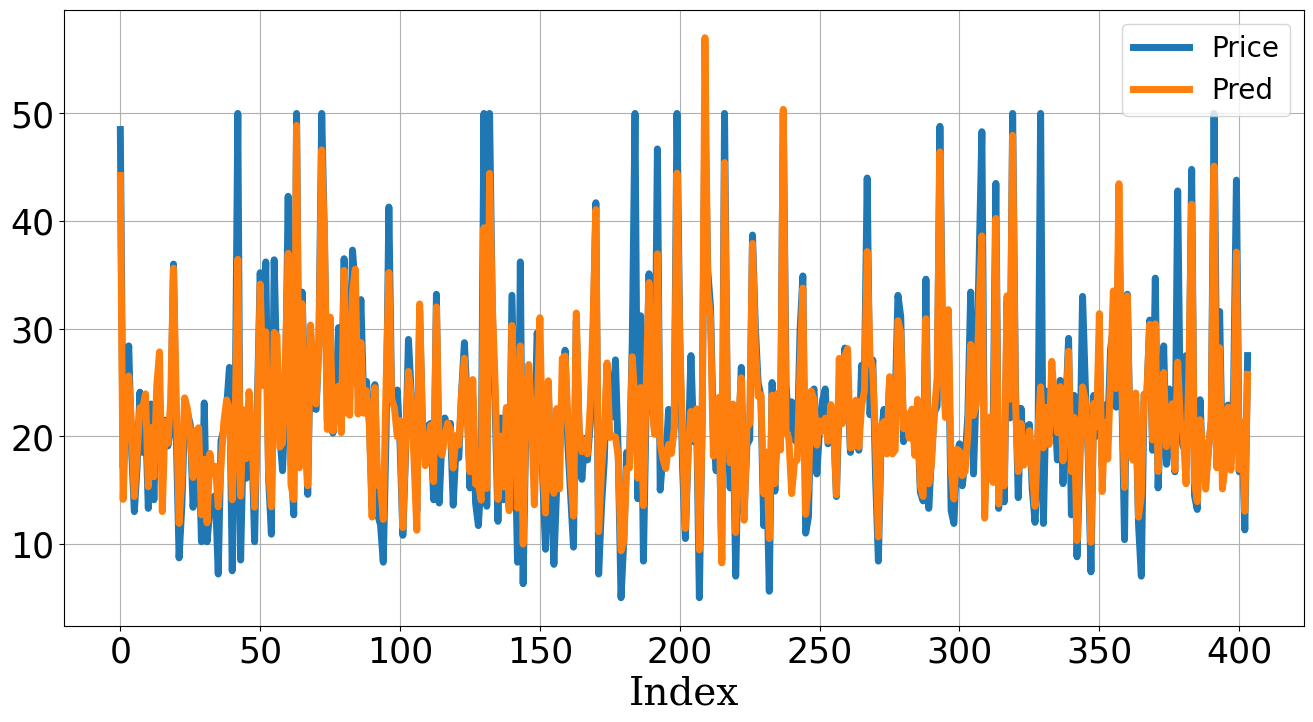

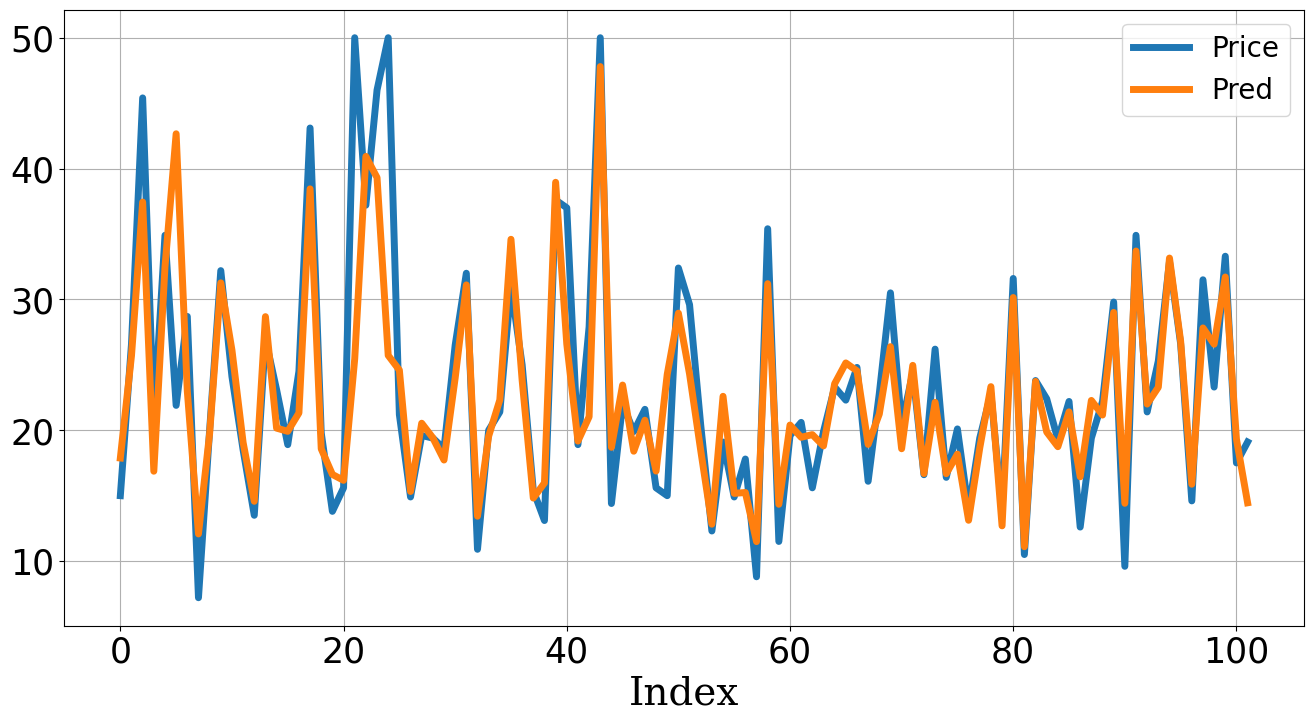

,MAE,MSE,MAPE
Train,2.38,12.99,0.12
Test,2.85,24.62,0.13


In [60]:
# 베스트 모델 로딩
model = load_model(FILENAME)

## 예측하기
Y_trpred = pd.DataFrame(model.predict(X_train), 
                        index=Y_train.index, columns=['Pred'])
Y_tepred = pd.DataFrame(model.predict(X_test), 
                        index=Y_test.index, columns=['Pred'])
plot_prediction(pd.concat([Y_train, Y_trpred], axis=1).reset_index().iloc[:,1:])
plot_prediction(pd.concat([Y_test, Y_tepred], axis=1).reset_index().iloc[:,1:])

# 분석 검증
Score_nn_early = evaluation_reg_trte(Y_train, Y_trpred, Y_test, Y_tepred)
display(Score_nn_early)